## –ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ —Å—Ç–æ–∏–º–æ—Å—Ç–∏ –∞–≤—Ç–æ–º–æ–±–∏–ª—è –ø–æ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∞–º

In [101]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import sys
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import ExtraTreeRegressor
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder,RobustScaler
from sklearn.model_selection import GridSearchCV

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sns.set()

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5


In [5]:
# –∑–∞—Ñ–∏–∫—Å–∏—Ä—É–µ–º –≤–µ—Ä—Å–∏—é –ø–∞–∫–µ—Ç–æ–≤, —á—Ç–æ–±—ã —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã –±—ã–ª–∏ –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º—ã:
!pip freeze > requirements.txt

In [6]:
# –≤—Å–µ–≥–¥–∞ —Ñ–∏–∫—Å–∏—Ä—É–π—Ç–µ RANDOM_SEED, —á—Ç–æ–±—ã –≤–∞—à–∏ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã –±—ã–ª–∏ –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º—ã!
RANDOM_SEED = 42

# Setup

In [7]:
VERSION    = 19
DIR_TRAIN  = '../input/autoru-parsed170321-converted/' # auto.ru –æ—Ç 17.03.21, –æ—Ç—Ñ–æ—Ä–º–∞—Ç–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –ø–æ–¥ —Ç–µ—Å—Ç–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.2
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# Data

In [8]:
!ls ../input/

autoru-parsed170321-converted  sf-dst-car-price-prediction


In [9]:
train = pd.read_csv(DIR_TRAIN+'cars_data.csv') # –º–æ–π –ø–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Func

In [10]:
### –§—É–Ω–∫—Ü–∏—è —Å—á–∏—Ç–∞–µ—Ç –æ–ø–∏—Å–∞—Ç–µ–ª—å–Ω—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–∞—Ç–∞—Å–µ—Ç–∞, –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
def get_stats(dataset):
    col_types = dataset.dtypes.reset_index()
    col_types.columns=['Name', 'type']
    num_cols = list(col_types[col_types['type'] !='object']['Name'])
    stats = pd.DataFrame(columns=['feature_name', 'min', 'max', 'median', 'q1', 'q3', 'iqr', 'l_border', 'r_border'])
    
    for i in range(len(num_cols)):
        q1 = dataset[num_cols[i]].quantile(0.25)
        q2 = dataset[num_cols[i]].median()
        q3 = dataset[num_cols[i]].quantile(0.75)
        iqr = q3 - q1
        left_outliers_border = q1 - 1.5 * iqr
        right_outliers_border = q3 + 1.5 * iqr
        minimum = dataset[num_cols[i]].min()
        maximum = dataset[num_cols[i]].max()
        stats.loc[i] = [num_cols[i], minimum, maximum, q2, q1, q3, iqr, left_outliers_border, right_outliers_border]
    
    return stats

In [11]:
### –§—É–Ω–∫—Ü–∏—è –∏—Å–ø—Ä–∞–≤–ª—è—é—â–∞—è —Å—Ç–æ–ª–±–µ—Ü —Å–æ —Å—Ä–æ–∫–æ–º –≤–ª–∞–¥–µ–Ω–∏—è
def ownership_fix(record):
    if record == None:
        return(None)
    digits = re.findall(r'\d+', record)
    letters = re.findall(r'\D+', record)
    if len(digits) == 2:
        return (int(digits[0])*12 + int(digits[1]))
    elif len(digits) == 1:
        if '–≥–æ' in letters[0] or '–ª–µ' in letters[0]:
            return(int(digits[0])*12)
        if '–º–µ' in letters[0]:
            return(int(digits[0]))

In [12]:
### –§—É–Ω–∫—Ü–∏—è –ø–æ–∏—Å–∫–∞ –æ–ø—Ü–∏–∏ –≤ —Å–ø–∏—Å–∫–µ –≤–æ–∑–º–æ–∂–Ω—ã—Ö –æ–ø—Ü–∏–π –¥–ª—è –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è dummy-–ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö
def find_equip (car, equip):
    if equip in car:
        return 1
    return 0

In [13]:
### –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Å—Ç–æ–ª–±—Ü–∞ —Å —Ç–µ–∫—Å—Ç–æ–≤—ã–º–∏ —Å–ª–æ–≤–∞—Ä—è–º–∏ –æ–ø—Ü–∏–π –∞–≤—Ç–æ–º–æ–±–∏–ª—è

# –°–ø–∏—Å–æ–∫ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –æ–ø—Ü–∏–π
test_options = ['12-inch-wheels',
                '12v-socket',
                '13-inch-wheels',
                '14-inch-wheels',
                '15-inch-wheels',
                '16-inch-wheels',
                '17-inch-wheels',
                '18-inch-wheels',
                '19-inch-wheels',
                '20-inch-wheels',
                '21-inch-wheels',
                '22-inch-wheels',
                '220v-socket',
                '23-inch-wheels',
                '24-inch-wheels',
                '25-inch-wheels',
                '27-inch-wheels',
                '360-camera',
                'abs',
                'activ-suspension',
                'adaptive-light',
                'adj-pedals',
                'advanced-frontlighting-system',
                'air-suspension',
                'airbag-2',
                'airbag-4',
                'airbag-6',
                'airbag-curtain',
                'airbag-driver',
                'airbag-passenger',
                'airbag-rear-side',
                'airbag-side',
                'airbrush',
                'alarm',
                'alcantara',
                'alloy-wheel-disks',
                'android-auto',
                'apple-carplay',
                'armored',
                'ashtray-and-cigarette-lighter',
                'asr',
                'audiopreparation',
                'audiosystem',
                'audiosystem-cd',
                'audiosystem-tv',
                'auto-cruise',
                'auto-mirrors',
                'auto-park',
                'automatic-lighting-control',
                'aux',
                'bas',
                'black-roof',
                'blind-spot',
                'bluetooth',
                'body-kit',
                'body-mouldings',
                'climate-control',
                'climate-control-1',
                'climate-control-2',
                'climate-control-3',
                'collision-prevention-assist',
                'combo-interior',
                'computer',
                'condition',
                'cooling-box',
                'cruise-control',
                'dark-interior',
                'decorative-interior-lighting',
                'door-sill-panel',
                'drive-mode-sys',
                'driver-seat-electric',
                'driver-seat-manual',
                'driver-seat-memory',
                'driver-seat-support',
                'driver-seat-updown',
                'drl'
                'drowsy-driver-alert-system',
                'e-adjustment-wheel',
                'easy-trunk-opening',
                'eco-leather',
                'electro-mirrors',
                'electro-rear-seat',
                'electro-seat',
                'electro-trunk',
                'electro-window-all',
                'electro-window-back',
                'electro-window-front',
                'electronic-gage-panel',
                'engine-proof',
                'entertainment-system-for-rear-seat-passengers',
                'esp',
                'fabric-seats',
                'feedback-alarm',
                'folding-front-passenger-seat',
                'folding-tables-rear',
                'front-camera',
                'front-centre-armrest',
                'front-seat-support',
                'front-seats-heat',
                'front-seats-heat-vent',
                'gbo',
                'glonass',
                'halogen',
                'hatch',
                'hcc',
                'heated-wash-system',
                'high-beam-assist',
                'immo',
                'immobiliser-not-standard',
                'isofix',
                'isofix-front',
                'keyless-entry',
                'knee-airbag',
                'laminated-safety-glass',
                'lane-keeping-assist',
                'laser-lights',
                'leather',
                'leather-gear-stick',
                'led-lights',
                'light-cleaner',
                'light-interior',
                'light-sensor',
                'lock',
                'massage-seats',
                'mirrors-heat',
                'multi-wheel',
                'multizone-climate-control',
                'music-super',
                'navigation',
                'night-vision',
                'paint-metallic',
                'panorama-roof',
                'park-assist-f',
                'park-assist-r',
                'parktronik',
                'passenger-seat-electric',
                'passenger-seat-manual',
                'passenger-seat-memory',
                'passenger-seat-updown',
                'power-child-locks-rear-doors',
                'power-latching-doors',
                'programmed-block-heater',
                'projection-display',
                'ptf'
                'rain-sensor',
                'rear-camera',
                'rear-seat-heat-vent',
                'rear-seats-heat',
                'reduce-spare-wheel',
                'remote-engine-start',
                'roller-blind-for-rear-window',
                'roller-blinds-for-rear-side-windows',
                'roof-rails',
                'seat-memory',
                'seat-transformation',
                'seats-2',
                'seats-4',
                'seats-5',
                'seats-6',
                'seats-7',
                'seats-8',
                'seats-9',
                'seats-heat',
                'servo',
                'spare-wheel',
                'sport-pedals',
                'sport-seats',
                'sport-suspension',
                'start-button',
                'start-stop-function',
                'steel-wheels',
                'steering-wheel-gear-shift-paddles',
                'third-rear-headrest',
                'third-row-seats',
                'tinted-glass',
                'traffic-sign-recognition',
                'turnbuckle',
                'tyre-pressure',
                'usb',
                'velvet-seats',
                'voice-recognition',
                'volume-sensor',
                'vsm',
                'wheel-configuration1',
                'wheel-configuration2',
                'wheel-configuration3',
                'wheel-heat',
                'wheel-leather',
                'wheel-memory',
                'wheel-power',
                'windcleaner-heat',
                'windscreen-heat',
                'wireless-charger',
                'xenon',
                'ya-auto']

def test_options_fix(record):
    options = []
    if type(record)==str:
        options_dict = json.loads(record)
        for key in options_dict:
            if key in test_options:
                options.append(key)
    return(options)

In [14]:
### –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞–∑–±–∏–≤–∫–∏ —Ç–µ–∫—Å—Ç–æ–≤–æ–≥–æ —Å–ø–∏—Å–∫–∞ –Ω–∞ —ç–ª–µ–º–µ–Ω—Ç—ã
def clear_text_list (text_list):
    clear_list = [element.strip("'[]") for element in text_list.split("', '")]
    return clear_list

In [15]:
### –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –Ω–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏–∑ –ø—Ä–æ–±–µ–≥–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π, —Å–≥—Ä—É–ø–ø–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –ø–æ –¥–≤—É–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º

def mileage_features(group1, group2, dataset):
    
    temp = train.pivot_table(values=['mileage'], index=[group1, group2], aggfunc=[np.min, np.max, np.mean, np.median, np.std]).reset_index()
    temp.columns = [
                    group1,
                    group2,
                    'min_mileage by ' + group1 + ' ' + group2,
                    'max_mileage by ' + group1 + ' ' + group2,
                    'mean_mileage by ' + group1 + ' ' + group2,
                    'median_mileage by ' + group1 + ' ' + group2,
                    'std_mileage by ' + group1 + ' ' + group2,
    ]
    temp.fillna(0, inplace=True)
    dataset = dataset.merge(temp, on=[group1, group2], how='left')
    
    return dataset

In [16]:
def preproc_test(df_input):
    '''–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞'''
    df_output = df_input.copy()
    
    # —É–±–∏—Ä–∞–µ–º –Ω–µ–Ω—É–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    test_to_drop = ['complectation_dict', 'image', 'model_info',
                'parsing_unixtime', 'sell_id', 'super_gen', 'vehicleConfiguration', 'priceCurrency']
    
    df_output.drop(test_to_drop, inplace=True, axis=1)
    
    # ################### fix ##############################################################
    # –ò—Å–ø—Ä–∞–≤–ª—è–µ–º –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è
    df_output.engineDisplacement=pd.to_numeric(df_output.engineDisplacement.str.strip(' LTR'))
    
    # –£ —ç–ª–µ–∫—Ç—Ä–∏—á–µ—Å–∫–∏—Ö –¥–≤–∏–≥–∞—Ç–µ–ª–µ–π —Å—Ç–∞–≤–∏–º –æ–±—ä–µ–º 0
    df_output.engineDisplacement.fillna(0, inplace=True)
    
    # –ò—Å–ø—Ä–∞–≤–ª—è–µ–º –º–æ—â–Ω–æ—Å—Ç—å –¥–≤–∏–≥–∞—Ç–µ–ª—è 
    df_output.enginePower = pd.to_numeric(df_output.enginePower.str.replace(u' N12', u''))
    
    # –ò—Å–ø—Ä–∞–≤–ª—è–µ–º —Å—Ç–æ–ª–±–µ—Ü —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –≤–ª–∞–¥–µ–ª—å—Ü–µ–≤ 
    df_output.–í–ª–∞–¥–µ–ª—å—Ü—ã = df_output.–í–ª–∞–¥–µ–ª—å—Ü—ã.apply(lambda x: x.strip(re.findall('\D+', x)[0]))
    df_output.–í–ª–∞–¥–µ–ª—å—Ü—ã = df_output.–í–ª–∞–¥–µ–ª—å—Ü—ã.astype(int)
    
    # –ü–µ—Ä–µ–≤–æ–¥–∏–º —Å—Ç–æ–ª–±–µ—Ü –í–ª–∞–¥–µ–Ω–∏–µ –≤ –º–µ—Å—è—Ü—ã
    df_output.–í–ª–∞–¥–µ–Ω–∏–µ.fillna('', inplace=True)
    df_output.–í–ª–∞–¥–µ–Ω–∏–µ = df_output.–í–ª–∞–¥–µ–Ω–∏–µ.apply(ownership_fix)
    
    # –ó–∞–ø–æ–ª–Ω–∏–º –µ–¥–∏–Ω—Å—Ç–≤–µ–Ω–Ω—ã–π Nan –≤ –ü–¢–° 
    df_output.–ü–¢–°.fillna('–î—É–±–ª–∏–∫–∞—Ç', inplace=True)
    
    # –û–±—Ä–∞–±–æ—Ç–∞–µ–º —Å—Ç–æ–ª–±–µ—Ü —Å –æ–ø—Ü–∏—è–º–∏
    df_output.equipment_dict = df_output.equipment_dict.apply(test_options_fix)
    
    
    
    return df_output

# EDA

–°—Ä–∞–≤–Ω–∏–º –¥–∞—Ç–∞—Å–µ—Ç—ã test –∏ train 

train –±—ã–ª –ø–æ–ª—É—á–µ–Ω –ø—É—Ç–µ–º –ø–∞—Ä—Å–∏–Ω–≥–∞ auto.ru –ø–æ —Å–æ—Å—Ç–æ—è–Ω–∏—é –Ω–∞ 17.03.21,–∏ –¥–∞–ª—å–Ω–µ–π—à–µ–π –æ–±—Ä–∞–±–æ—Ç–∫–æ–π —Å —Ü–µ–ª—å—é –ø—Ä–∏–≤–µ–¥–µ–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö –∫ –≤–∏–¥—É, –∞–Ω–∞–ª–æ–≥–∏—á–Ω–æ–º—É test. –î–ª—è —ç–∫–æ–Ω–æ–º–∏–∏ –≤—Ä–µ–º–µ–Ω–∏ –∏ —Ä–µ—Å—É—Ä—Å–æ–≤ –ø–∞—Ä—Å–∏–ª–∏—Å—å —Ç–æ–ª—å–∫–æ —Ç–µ –º–∞—Ä–∫–∏ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç –≤ test

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39136 entries, 0 to 39135
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             39136 non-null  object 
 1   brand                39136 non-null  object 
 2   car_url              39136 non-null  object 
 3   color                39136 non-null  object 
 4   description          38269 non-null  object 
 5   engineDisplacement   39136 non-null  float64
 6   enginePower          39136 non-null  int64  
 7   equipment_dict       39136 non-null  object 
 8   fuelType             39136 non-null  object 
 9   mileage              39136 non-null  float64
 10  modelDate            39136 non-null  int64  
 11  model_name           39136 non-null  object 
 12  name                 39136 non-null  object 
 13  numberOfDoors        39136 non-null  int64  
 14  productionDate       39136 non-null  int64  
 15  vehicleTransmission  39136 non-null 

–ü—Ä–æ–ø—É—Å–∫–∏ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç —Ç–æ–ª—å–∫–æ –≤ —Å—Ç–æ–ª–±—Ü–µ —Å–æ —Å—Ä–æ–∫–æ–º –≤–ª–∞–¥–µ–Ω–∏—è –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–º –∏ —É –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç —Ç–µ–∫—Å—Ç–æ–≤–æ–µ –æ–ø–∏—Å–∞–Ω–∏–µ.

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

–í test –∫–∞—Ä—Ç–∏–Ω–∞ –∞–Ω–∞–ª–æ–≥–∏—á–Ω–∞—è, –º–Ω–æ–≥–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ —Å—Ç–æ–ª–±—Ü–µ —Å–æ —Å—Ä–æ–∫–æ–º –≤–ª–∞–¥–µ–Ω–∏—è, —Å–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ complectation_dict –∏ –ø—Ä–∏–±–ª–∏–∑–∏—Ç–µ–ª—å–Ω–æ —Ç—Ä–µ—Ç—å –∑–∞–ø–∏—Å–µ–π –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –¥–ª—è equipment_dict

–ü—Ä–æ–≤–µ–¥–µ–º –ø–µ—Ä–≤–∏—á–Ω—É—é –æ–±—Ä–∞–±–æ—Ç–∫—É test

In [19]:
test = preproc_test(test)

–ü–æ—Å—á–∏—Ç–∞–µ–º –æ–ø–∏—Å–∞—Ç–µ–ª—å–Ω—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –¥–ª—è train –∏ test

In [20]:
train_stats = get_stats(train)
train_stats

feature_name      min         max     median        q1         q3        iqr   l_border   r_border
0  engineDisplacement      0.0         6.6        2.0       1.6        3.0        1.4       -0.5        5.1
1         enginePower     41.0       639.0      170.0     131.0      238.0      107.0      -29.5      398.5
2             mileage      1.0   1000000.0   129000.0   75000.0   195000.0   120000.0  -105000.0   375000.0
3           modelDate   1937.0      2020.0     2011.0    2006.0     2014.0        8.0     1994.0     2026.0
4       numberOfDoors      2.0         5.0        5.0       4.0        5.0        1.0        2.5        6.5
5      productionDate   1948.0      2021.0     2012.0    2007.0     2016.0        9.0     1993.5     2029.5
6           –í–ª–∞–¥–µ–ª—å—Ü—ã      1.0         3.0        2.0       1.0        3.0        2.0       -2.0        6.0
7            –í–ª–∞–¥–µ–Ω–∏–µ      1.0       519.0       36.0      17.0       69.0       52.0      -61.0      147.0
8               Price  20000.0  57000000.0  1017500.0  569000.0  1856000.0  1287000.0 -1361500.0  3786500.0

In [21]:
test_stats = get_stats(test)
test_stats

feature_name     min        max    median       q1        q3       iqr      l_border   r_border
0  engineDisplacement     0.0        6.6       2.0      1.8       3.0       1.2  2.220446e-16       4.80
1         enginePower    30.0      639.0     169.0    125.0     233.0     108.0 -3.700000e+01     395.00
2             mileage     1.0  1000000.0  149779.5  91153.5  215000.0  123846.5 -9.461625e+04  400769.75
3           modelDate  1904.0     2020.0    2008.0   2004.0    2012.0       8.0  1.992000e+03    2024.00
4       numberOfDoors     0.0        5.0       5.0      4.0       5.0       1.0  2.500000e+00       6.50
5      productionDate  1904.0     2020.0    2011.0   2006.0    2014.0       8.0  1.994000e+03    2026.00
6           –í–ª–∞–¥–µ–ª—å—Ü—ã     1.0        3.0       2.0      1.0       3.0       2.0 -2.000000e+00       6.00
7            –í–ª–∞–¥–µ–Ω–∏–µ     1.0      514.0      42.0     22.0      78.0      56.0 -6.200000e+01     162.00

## –ü—Ä–æ–π–¥–µ–º—Å—è –ø–æ –ø—Ä–∏–∑–Ω–∞–∫–∞–º –≤ test –∏ —Å—Ä–∞–≤–Ω–∏–º –∏—Ö —Å train, –≤ —Å–ª—É—á–∞–µ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤–∏—è –∞–Ω–∞–ª–æ–≥–∏—á–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞

### bodyType - –¢–∏–ø –∫—É–∑–æ–≤–∞

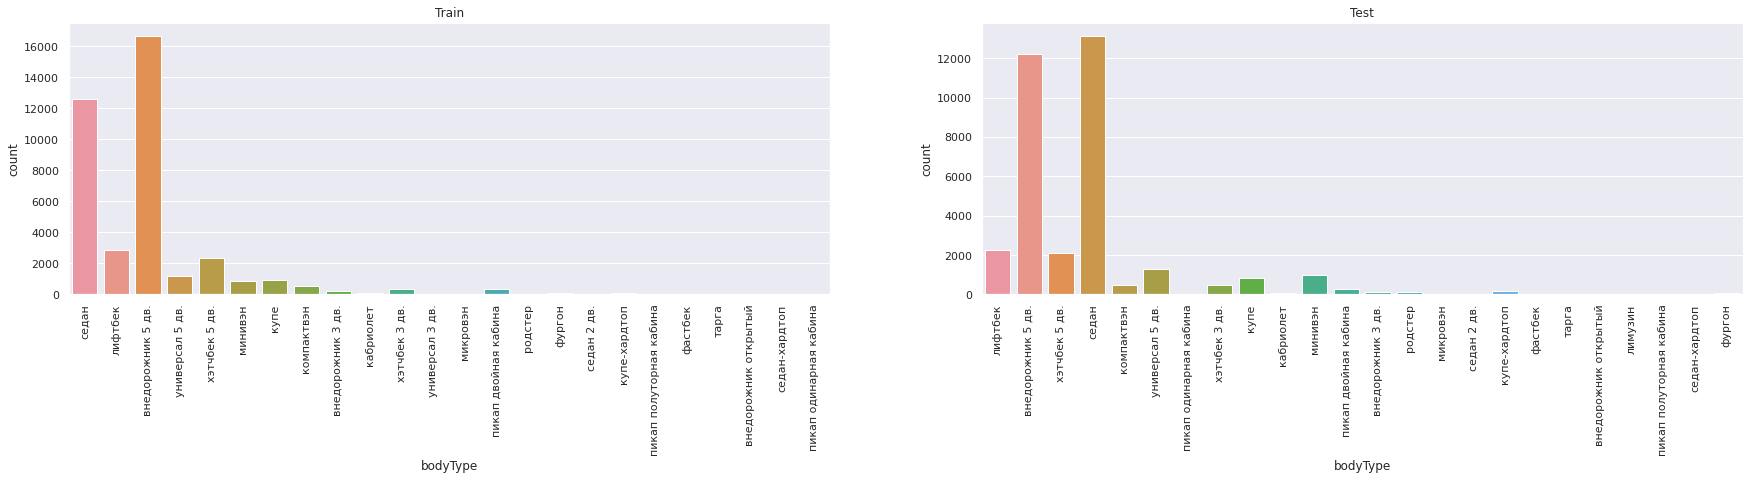

In [22]:
fig, ax =plt.subplots(1,2, figsize=(30,5))
sns.countplot(x='bodyType', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='bodyType', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

–ü—Ä–∏–∑–Ω–∞–∫ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π. –í test –ø—Ä–µ–æ–±–ª–∞–¥–∞—é—Ç —Å–µ–¥–∞–Ω—ã, –≤ —Ç–æ –≤—Ä–µ–º—è –∫–∞–∫ –≤ train - –≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫–∏

### brand - –ú–∞—Ä–∫–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª—è

–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫, –ø–µ—Ä–µ—á–µ–Ω—å –º–∞—Ä–æ–∫ —Å–æ–≤–ø–∞–¥–∞–µ—Ç


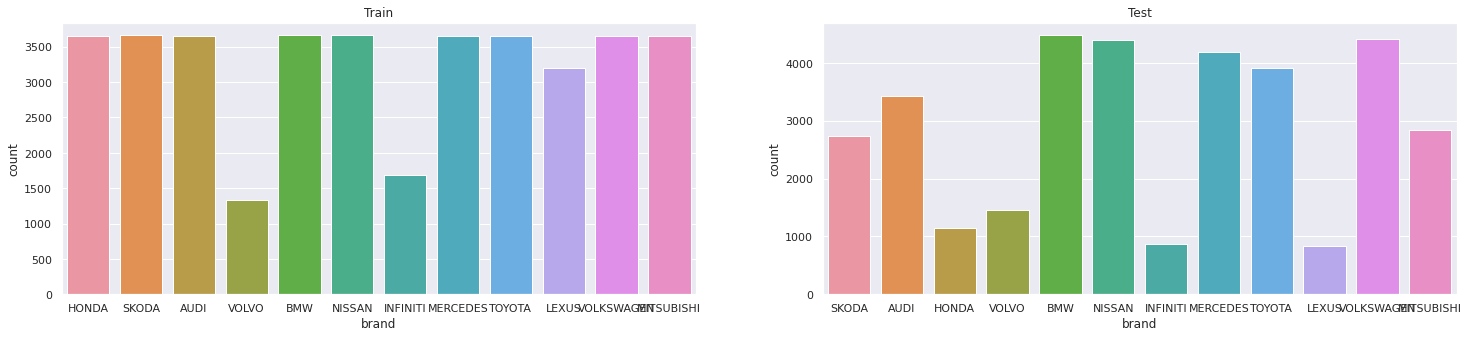

In [23]:
fig, ax =plt.subplots(1,2, figsize=(25,5))
sns.countplot(x='brand', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='brand', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–í train –¥–∞–Ω–Ω—ã–µ –ø–æ –Ω–µ–∫–æ—Ç–æ—Ä—ã–º –º–∞—Ä–∫–∞–º –∫–∞–∫-–±—É–¥—Ç–æ –æ–±—Ä–µ–∑–∞–Ω—ã. –≠—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å —Ç–µ–º, —á—Ç–æ –≤—ã–≥—Ä—É–∑–∫–∞ –ø—Ä–æ–∏–∑–≤–æ–¥–∏–ª–∞—Å—å –ø–æ –º–∞—Ä–∫–∞–º –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π, –∞ auto.ru –ª–∏–º–∏—Ç–∏—Ä—É–µ—Ç –≤—ã–¥–∞—á—É –ø–æ –º–∞—Ä–∫–∞–º 99-—é —Å—Ç—Ä–∞–Ω–∏—Ü–∞–º–∏.

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –ø–æ –º–∞—Ä–∫–∞–º –∞–≤—Ç–æ

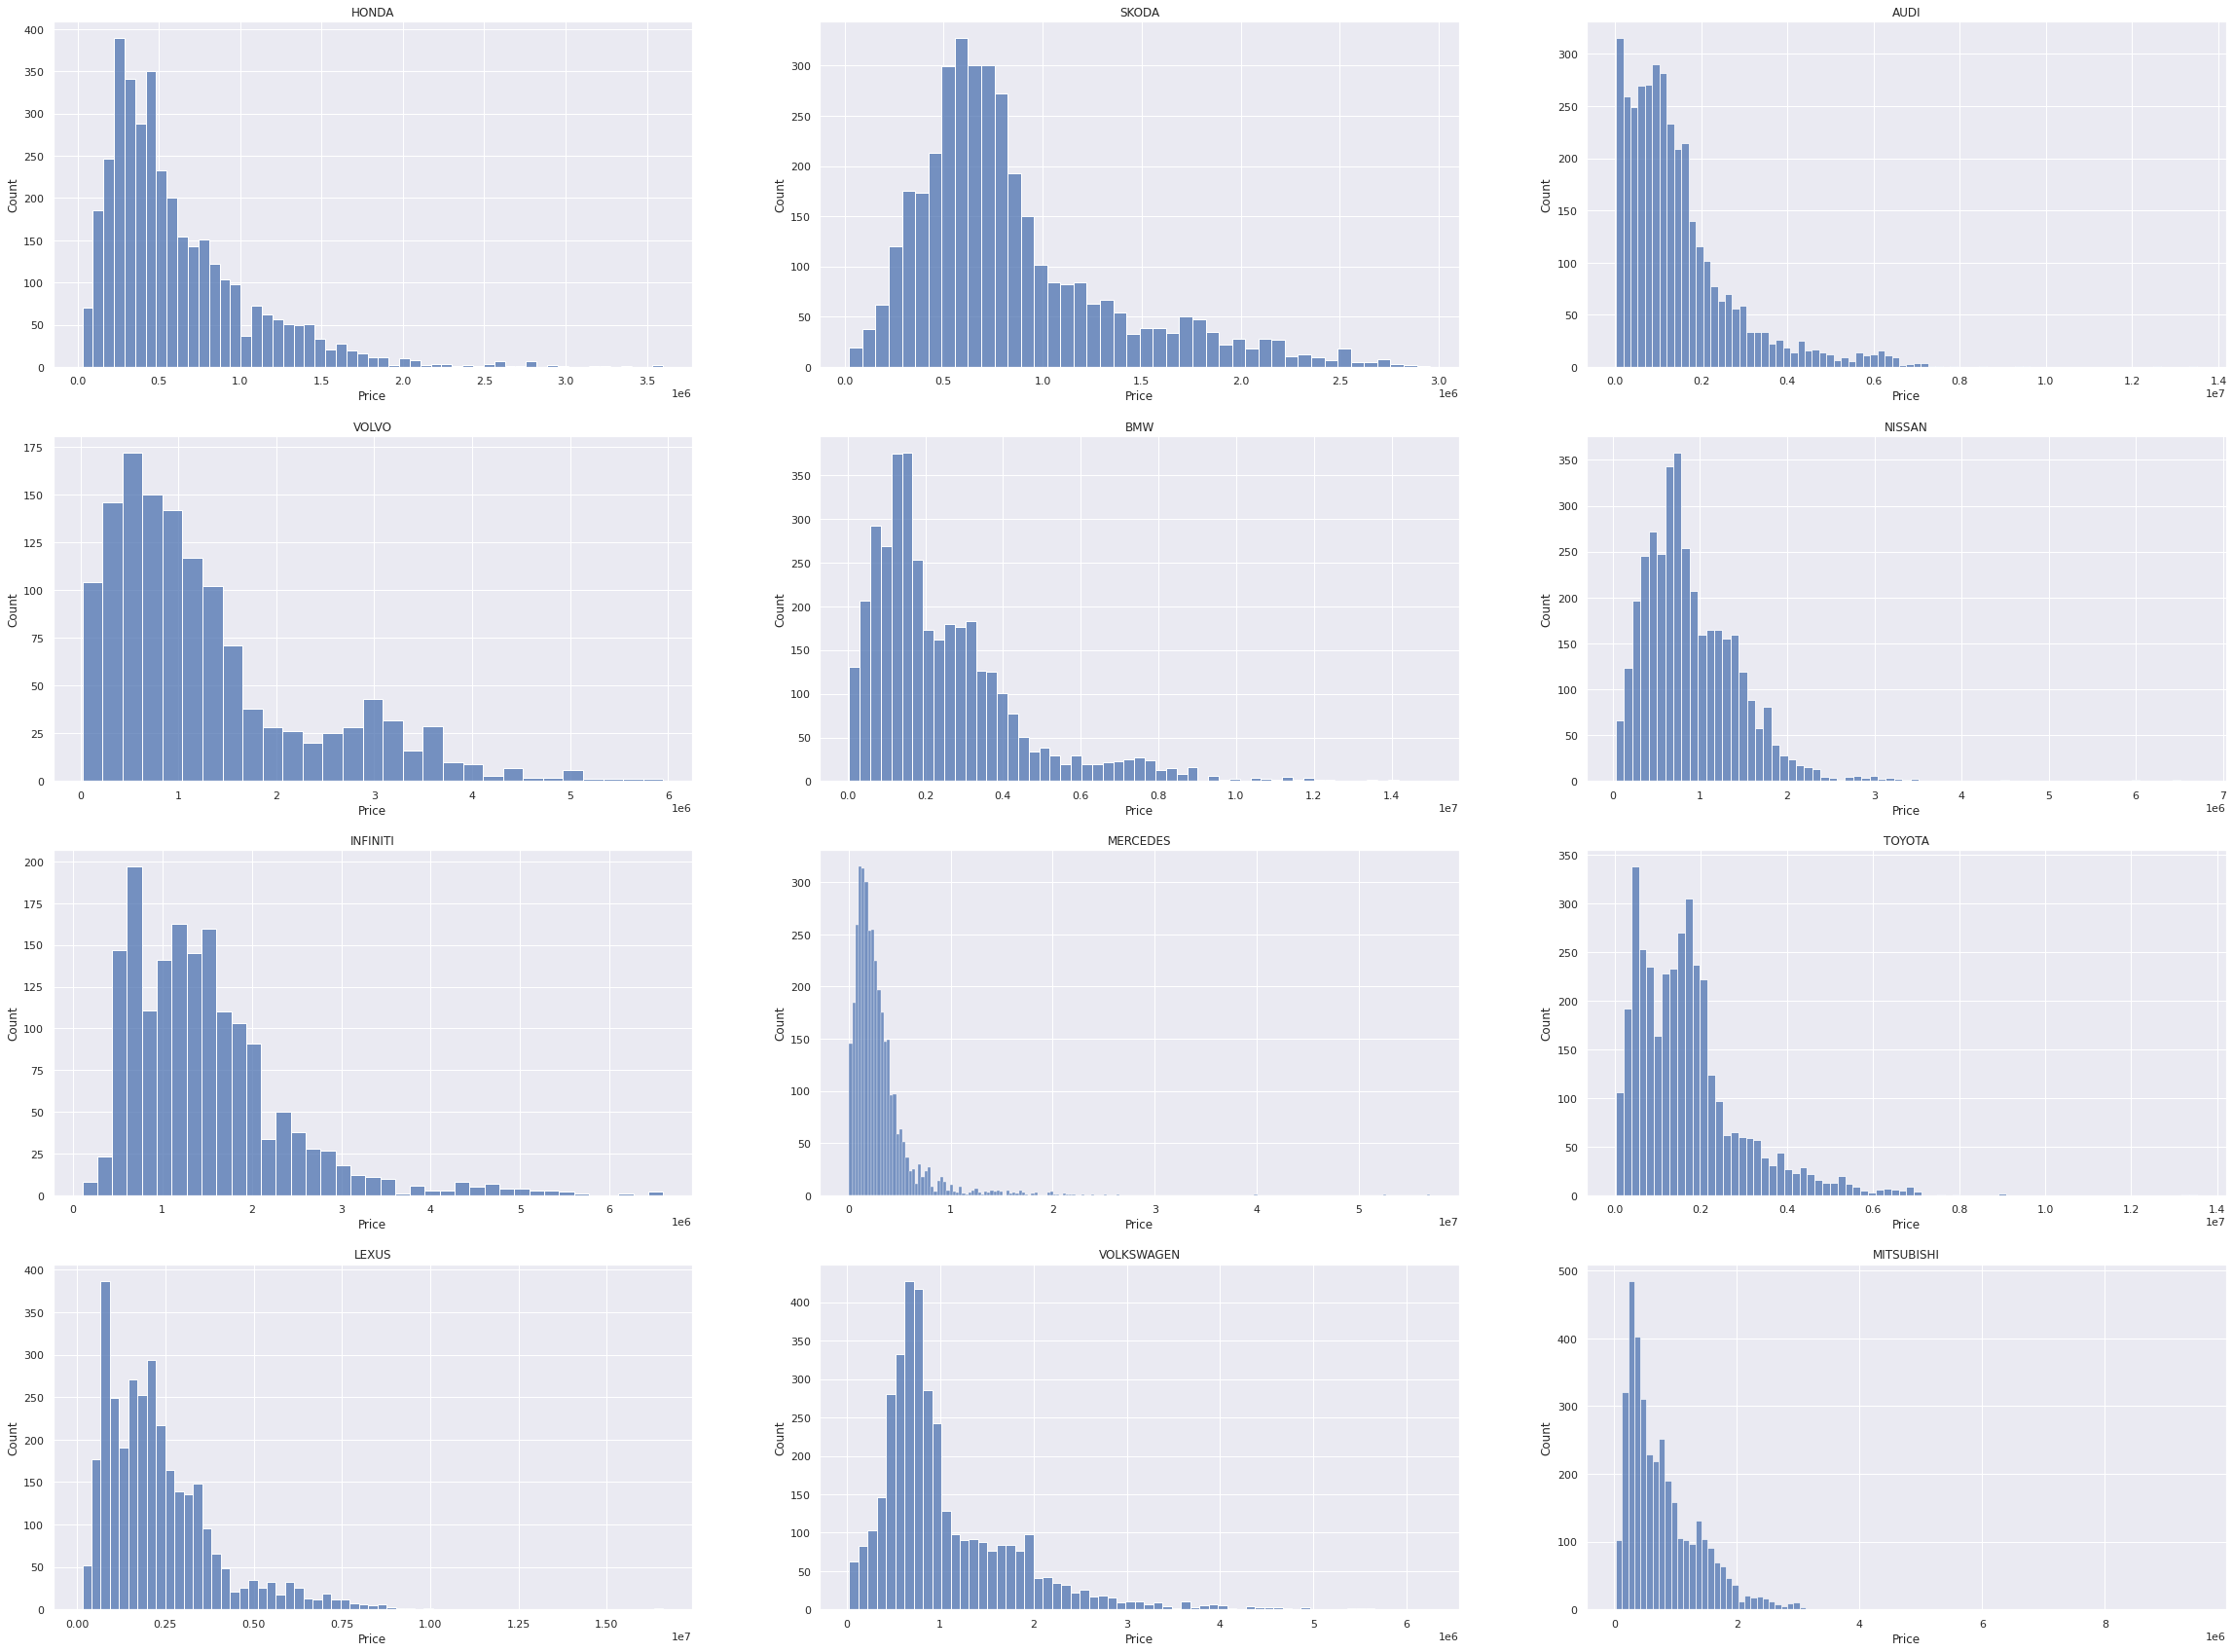

In [24]:
fig, ax = plt.subplots(4,3, figsize=(40,30))
for i in range(4):
    for j in range(3):
        sns.histplot(x = train.Price[train.brand==train.brand.unique()[i*3+j]], ax=ax[i,j])
        ax[i,j].set_title(train.brand.unique()[i*3+j])
fig.show()          



–ü—Ä–∞–≤—ã–µ —Ö–≤–æ—Å—Ç—ã –ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–æ —Å–≤—è–∑–∞–Ω—ã —Å –Ω–∞–ª–∏—á–∏–µ–º –≤ –≤—ã–¥–∞—á–µ –±/—É –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π –Ω–æ–≤—ã—Ö –º–∞—à–∏–Ω —Å –≤—ã—Å–æ–∫–æ–π —Ü–µ–Ω–æ–π, –∫–æ—Ç–æ—Ä—ã–µ –∞–≤—Ç–æ—Å–∞–ª–æ–Ω—ã –≤—ã—Å—Ç–∞–≤–ª—è—é—Ç –Ω–∞ –ø—Ä–æ–¥–∞–∂—É –∫–∞–∫ –±/—É.
–ù–∞ –≤—ã–±—Ä–æ—Å—ã –Ω–∞–¥–æ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –æ—Ç–¥–µ–ª—å–Ω–æ.

In [25]:
outliers = train[
    (train.Price <= train_stats[train_stats.feature_name=='Price'].iloc[0]['l_border']) |
    (train.Price >= train_stats[train_stats.feature_name=='Price'].iloc[0]['r_border'])
]

In [26]:
outliers

bodyType       brand                                            car_url       color                                        description  engineDisplacement  enginePower                                     equipment_dict fuelType        mileage  modelDate model_name                            name  numberOfDoors  productionDate vehicleTransmission    vendor  –í–ª–∞–¥–µ–ª—å—Ü—ã  –í–ª–∞–¥–µ–Ω–∏–µ       –ü–¢–°  –ü—Ä–∏–≤–æ–¥   –†—É–ª—å           –°–æ—Å—Ç–æ—è–Ω–∏–µ     –¢–∞–º–æ–∂–Ω—è    Price
5                –ª–∏—Ñ—Ç–±–µ–∫        AUDI  https://auto.ru/cars/used/sale/audi/a7/1102646...       —Å–µ—Ä—ã–π  #cme600-0b6e02ff-7a68-11eb-be32-000c29224324–°–æ...                 3.0          249  ['body-kit', 'alloy-wheel-disks', 'eco-leather...   –¥–∏–∑–µ–ª—å    3518.000000       2018         A7   45 TDI 3.0d AT (249 –ª.—Å.) 4WD              5            2020      –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN          2       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  5870000
11     –≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 5 –¥–≤.        AUDI  https://auto.ru/cars/used/sale/audi/sq7/110282...       —Å–µ—Ä—ã–π  –¢–æ–ª—å–∫–æ –∏–∑ –ì–µ—Ä–º–∞–Ω–∏–∏ ! –°–æ—Å—Ç–æ—è–Ω–∏–µ –Ω–∞ 30/40 —Ç—ã—Å—è—á ...                 4.0          435                                                 []   –¥–∏–∑–µ–ª—å  126800.000000       2016        SQ7          4.0d AT (435 –ª.—Å.) 4WD              5            2017      –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN          1       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  4499000
23     –≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 5 –¥–≤.        AUDI  https://auto.ru/cars/used/sale/audi/q8/1102460...      —á—ë—Ä–Ω—ã–π  ‚úÖ –°–æ—Å—Ç–æ—è–Ω–∏–µ –Ω–æ–≤–æ–≥–æ –∞–≤—Ç–æ–º–æ–±–∏–ª—è‚úÖ –ü–¢–° –æ—Ä–∏–≥–∏–Ω–∞–ª‚úÖ 1...                 3.0          340  ['asr', 'airbag-driver', 'hsa', 'airbag-curtai...   –±–µ–Ω–∑–∏–Ω   72000.000000       2018         Q8   55 TFSI 3.0 AT (340 –ª.—Å.) 4WD              5            2019      –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN          1       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  5700000
56                 —Å–µ–¥–∞–Ω        AUDI  https://auto.ru/cars/used/sale/audi/a6/1102265...      —á—ë—Ä–Ω—ã–π  - –ù–∞—à –∞–≤—Ç–æ—Å–∞–ª–æ–Ω –æ–±–µ—Å–ø–µ—á–∏–≤–∞–µ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω—É—é –±–µ–∑–æ...                 2.0          245  ['cruise-control', 'multi-wheel', 'active-stee...   –±–µ–Ω–∑–∏–Ω   10195.000000       2018         A6  45 TFSI 2.0 AMT (245 –ª.—Å.) 4WD              4            2019    —Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è  EUROPEAN          1       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  3950000
74     –≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 5 –¥–≤.        AUDI  https://auto.ru/cars/used/sale/audi/q8/1102478...       –±–µ–ª—ã–π  –í–∞—à –≤—ã–±–æ—Ä –∏ –í–∞—à–µ –≤—Ä–µ–º—è ‚Äî –Ω–∞—à–∏ –≥–ª–∞–≤–Ω—ã–µ –ø—Ä–∏–æ—Ä–∏—Ç–µ...                 3.0          249  ['asr', 'airbag-driver', 'airbag-passenger', '...   –¥–∏–∑–µ–ª—å    5859.000000       2018         Q8   45 TDI 3.0d AT (249 –ª.—Å.) 4WD              5            2019      –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN          1       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  5730000
...                  ...         ...                                                ...         ...                                                ...                 ...          ...                                                ...      ...            ...        ...        ...                             ...            ...             ...                 ...       ...        ...       ...       ...     ...    ...                 ...         ...      ...
38674  –≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 5 –¥–≤.  VOLKSWAGEN  https://auto.ru/cars/used/sale/volkswagen/toua...       —Å–∏–Ω–∏–π  üí∏–í—ã–≥–æ–¥–∞ –¥–æ 100 000 —Ä—É–±–ª–µ–π –ø—Ä–∏ –ø–æ

In [27]:
outliers.brand.unique()

array(['AUDI', 'BMW', 'VOLVO', 'NISSAN', 'INFINITI', 'MERCEDES', 'TOYOTA',
       'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'], dtype=object)

–ü–æ—Å–º–æ—Ç—Ä–∏–º –∞–≤—Ç–æ–º–æ–±–∏–ª–∏ –∫–∞–∫–∏—Ö –≥–æ–¥–æ–≤ –≤—ã–ø—É—Å–∫–∞ –≤—ã—à–ª–∏ –ø–æ —Ü–µ–Ω–µ –∑–∞ 1,5 –º–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω—ã—Ö —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –æ—Ç 1 –∏ 3 –∫–≤–∞—Ä—Ç–∏–ª–µ–π

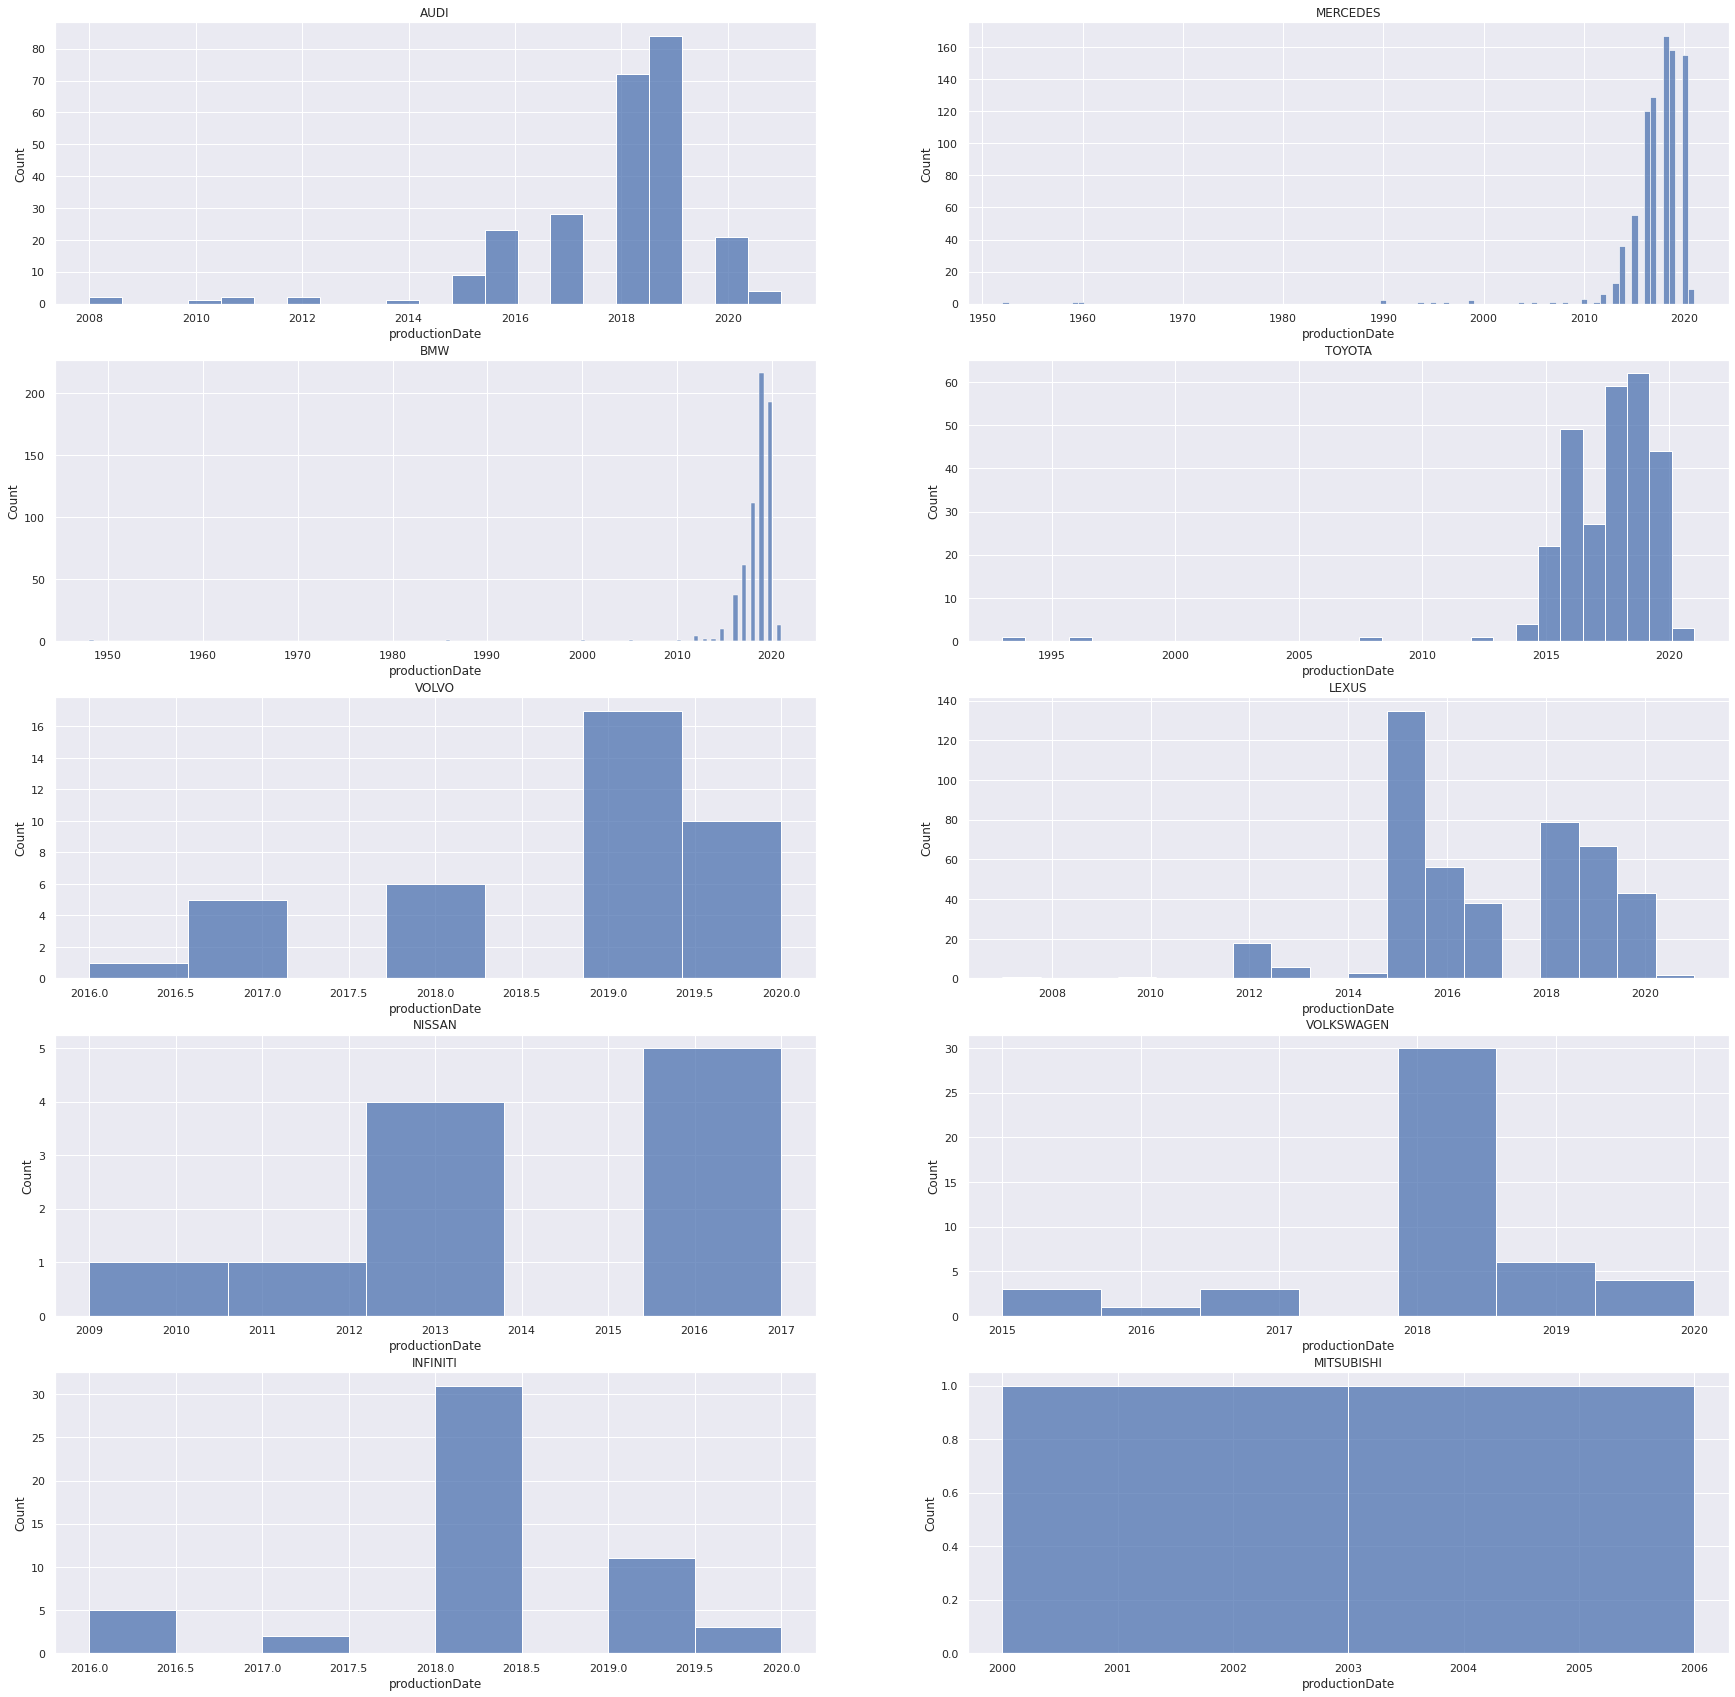

In [28]:
fig, ax = plt.subplots(5,2, figsize=(30,30))
for i in range(5):
    for j in range(2):
        #print(i, j, i+j, train.brand.unique()[i*5+j])
        sns.histplot(x = outliers.productionDate[outliers.brand==outliers.brand.unique()[i+j*5]], ax=ax[i,j])
        ax[i,j].set_title(outliers.brand.unique()[i+j*5])
fig.show()   

–ü—Ä–æ–≤–µ—Ä–∏–º AUDI, MERCEDES, BMW, TOYOTA, LEXUS, NISSAN —É –æ—Å—Ç–∞–ª—å–Ω—ã—Ö –º–∞—Ä–æ–∫ –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞ –¥–ª—è –¥–æ—Ä–æ–≥–∏—Ö –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π –∫–∞–∂–µ—Ç—Å—è –ø—Ä–∏–µ–º–ª–µ–º—ã–º

In [29]:
outliers[outliers['brand'].isin(['AUDI', 'MERCEDES', 'BMW', 'TOYOTA', 'LEXUS', 'NISSAN']) & (outliers.productionDate<=2010)]

bodyType     brand                                            car_url        color                                        description  engineDisplacement  enginePower                                     equipment_dict fuelType   mileage  modelDate    model_name                              name  numberOfDoors  productionDate vehicleTransmission    vendor  –í–ª–∞–¥–µ–ª—å—Ü—ã  –í–ª–∞–¥–µ–Ω–∏–µ       –ü–¢–°  –ü—Ä–∏–≤–æ–¥   –†—É–ª—å           –°–æ—Å—Ç–æ—è–Ω–∏–µ     –¢–∞–º–æ–∂–Ω—è     Price
2035              –∫–∞–±—Ä–∏–æ–ª–µ—Ç      AUDI  https://auto.ru/cars/used/sale/audi/r8/1102811...      –∫—Ä–∞—Å–Ω—ã–π  –ü–æ–ª–Ω—ã–π –≠–∫—Å–∫–ª—é–∑–∏–≤–ï–¥–∏–Ω—Å—Ç–≤–µ–Ω–Ω–∞—è –≤ –†–æ—Å—Å–∏–∏–ö—É–ø–ª–µ–Ω–∞ –ø...                 5.2          525  ['asr', 'esp', 'lane-keeping-assist', 'airbag-...   –±–µ–Ω–∑–∏–Ω   33000.0       2007            R8        V10 5.2 AMT (525 –ª.—Å.) 4WD              2            2010    —Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è  EUROPEAN          1       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   6500000
2211                   –∫—É–ø–µ      AUDI  https://auto.ru/cars/used/sale/audi/r8/1100775...        –±–µ–ª—ã–π  –°—Ç–æ–∏—Ç –¥–≤–∏–≥–∞—Ç–µ–ª—å (5.2), –∫–æ—Ä–æ–±–∫–∞ –∏ —Ç—Ä–∞–Ω—Å–º–∏—Å—Å–∏—è –æ...                 5.2          525  ['alloy-wheel-disks', 'rain-sensor', 'light-se...   –±–µ–Ω–∑–∏–Ω   42100.0       2007            R8        V10 5.2 AMT (525 –ª.—Å.) 4WD              2            2008    —Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è  EUROPEAN          3       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   3999000
2225                   –∫—É–ø–µ      AUDI  https://auto.ru/cars/used/sale/audi/r8/1102702...        –±–µ–ª—ã–π  –û—Ç–ª–∏—á–Ω–æ–µ —Å–æ—Å—Ç–æ—è–Ω–∏–µ.–í –∑–∞–ª–æ–≥–∞—Ö –∏ —Ç.–¥. –Ω–µ —á–∏—Å–ª–∏—Ç—Å...                 4.2          420  ['esp', 'airbag-driver', 'airbag-side', 'airba...   –±–µ–Ω–∑–∏–Ω   13860.0       2007            R8         V8 4.2 AMT (420 –ª.—Å.) 4WD              2            2008    —Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è  EUROPEAN          1       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–æ–ª–Ω—ã–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   4500000
10574           —Å–µ–¥–∞–Ω 2 –¥–≤.       BMW  https://auto.ru/cars/used/sale/bmw/321/1092197...   –∫–æ—Ä–∏—á–Ω–µ–≤—ã–π  1948 BMW 3216-—Ü–∏–ª–∏–Ω–¥—Ä–æ–≤—ã–π –¥–≤—É—Ö–¥–≤–µ—Ä–Ω—ã–π —Å–µ–¥–∞–Ω, –≤...                 2.0           46                                                 []   –±–µ–Ω–∑–∏–Ω      10.0       1937           321                  2.0 MT (46 –ª.—Å.)              2            1948        –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∞—è  EUROPEAN          3      85.0  –û—Ä–∏–≥–∏–Ω–∞–ª  –∑–∞–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   5000000
12592                  –∫—É–ø–µ       BMW  https://auto.ru/cars/used/sale/bmw/m3/10859807...        —Å–µ—Ä—ã–π  –ü–æ–ª–Ω—ã–π —Å—Ç–æ–∫ –≤ –∫–æ–ª–ª–µ–∫—Ü–∏–æ–Ω–Ω–æ–º —Å–æ—Å—Ç–æ—è–Ω–∏–∏ ,—Ü–≤–µ—Ç –∑–∞...                 4.0          420  ['cruise-control', 'multi-wheel', 'ashtray-and...   –±–µ–Ω–∑–∏–Ω   25500.0       2007            M3                4.0 AMT (420 –ª.—Å.)              2            2010    —Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è  EUROPEAN          2       NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –∑–∞–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   3999000
12807                 —Å–µ–¥–∞–Ω       BMW  https://auto.ru/cars/used/sale/bmw/7er/1102808...      –≥–æ–ª—É–±–æ–π  –ê–≤—Ç–æ–º–æ–±–∏–ª—å –Ω–µ –±–∏—Ç, –Ω–µ –∫—Ä–∞—à–µ–Ω. –í—Å–µ –≤ –æ—Ä–∏–≥–∏–Ω–∞–ª–µ....                 3.4          192  ['electro-window-back', 'cruise-control', 'ele...   –±–µ–Ω–∑–∏–Ω   60000.0       1977           7ER            735i 3.4 AT (192 –ª.—Å.)              4            1986      –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN          1       6.0  –û—Ä–∏–≥–∏–Ω–∞–ª  –∑–∞–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   4000000
13243     –≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–

–ù—É –≤—Ä–æ–¥–µ –≤—Å–µ –≤ –ø–æ—Ä—è–¥–∫–µ - –≤ –æ—Å–Ω–æ–≤–Ω–æ–º —ç–∫—Å–∫–ª—é–∑–∏–≤–Ω—ã–µ –º–∞—à–∏–Ω—ã, –µ—Å—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ –∑–∞–≤—ã—à–µ–Ω–Ω—ã—Ö —Ü–µ–Ω, –Ω–æ —É–¥–∞–ª—è—Ç—å –∏—Ö —Ä—É–∫–∞–º–∏ –Ω–µ –±—É–¥–µ–º.

### car_url - –°—Å—ã–ª–∫–∞ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü—É –æ–±—ä—è–≤–ª–µ–Ω–∏—è. –£–±–∏—Ä–∞–µ–º.

### color - —Ü–≤–µ—Ç –∞–≤—Ç–æ–º–æ–±–∏–ª—è

In [30]:
sorted(test.color.unique())

['–±–µ–∂–µ–≤—ã–π',
 '–±–µ–ª—ã–π',
 '–≥–æ–ª—É–±–æ–π',
 '–∂—ë–ª—Ç—ã–π',
 '–∑–µ–ª—ë–Ω—ã–π',
 '–∑–æ–ª–æ—Ç–∏—Å—Ç—ã–π',
 '–∫–æ—Ä–∏—á–Ω–µ–≤—ã–π',
 '–∫—Ä–∞—Å–Ω—ã–π',
 '–æ—Ä–∞–Ω–∂–µ–≤—ã–π',
 '–ø—É—Ä–ø—É—Ä–Ω—ã–π',
 '—Ä–æ–∑–æ–≤—ã–π',
 '—Å–µ—Ä–µ–±—Ä–∏—Å—Ç—ã–π',
 '—Å–µ—Ä—ã–π',
 '—Å–∏–Ω–∏–π',
 '—Ñ–∏–æ–ª–µ—Ç–æ–≤—ã–π',
 '—á—ë—Ä–Ω—ã–π']

In [31]:
sorted(train.color.unique())

['–±–µ–∂–µ–≤—ã–π',
 '–±–µ–ª—ã–π',
 '–≥–æ–ª—É–±–æ–π',
 '–∂—ë–ª—Ç—ã–π',
 '–∑–µ–ª—ë–Ω—ã–π',
 '–∑–æ–ª–æ—Ç–∏—Å—Ç—ã–π',
 '–∫–æ—Ä–∏—á–Ω–µ–≤—ã–π',
 '–∫—Ä–∞—Å–Ω—ã–π',
 '–æ—Ä–∞–Ω–∂–µ–≤—ã–π',
 '–ø—É—Ä–ø—É—Ä–Ω—ã–π',
 '—Ä–æ–∑–æ–≤—ã–π',
 '—Å–µ—Ä–µ–±—Ä–∏—Å—Ç—ã–π',
 '—Å–µ—Ä—ã–π',
 '—Å–∏–Ω–∏–π',
 '—Ñ–∏–æ–ª–µ—Ç–æ–≤—ã–π',
 '—á—ë—Ä–Ω—ã–π']

–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫. –°–ø–∏—Å–æ–∫ —Ü–≤–µ—Ç–æ–≤ –∏–¥–µ–Ω—Ç–∏—á–µ–Ω –≤ train –∏ test

<AxesSubplot:xlabel='color', ylabel='count'>

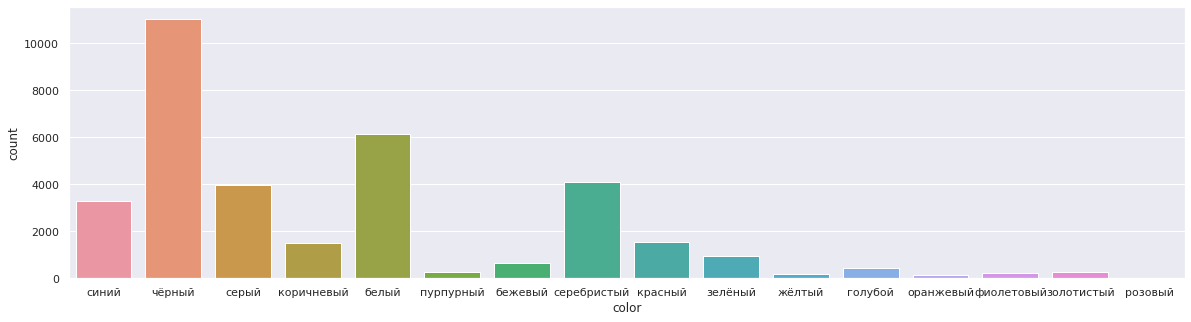

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x='color', ax=ax, data=test)

### complectation_dict –≤ test
–í—ã–≥–ª—è–¥–∏—Ç –∫–∞–∫ –∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ –∞–≤—Ç–æ–º–æ–±–∏–ª—è. –í –ø—Ä–∏–∑–Ω–∞–∫–µ —Å–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤. –£–±–∏—Ä–∞–µ–º

### description - –¢–µ–∫—Å—Ç–æ–≤—ã–µ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –∫ –æ–±—ä—è–≤–ª–µ–Ω–∏—é
–ú–æ–∂–µ—Ç –±—ã—Ç—å –ø–æ–ª–µ–∑–µ–Ω, –Ω–æ –Ω–∞–¥–æ –ø—Ä–∏–º–µ–Ω—è—Ç—å –∞–Ω–∞–ª–∏–∑ —Ç–µ–∫—Å—Ç–∞. –ù–∞–ø—Ä–∏–º–µ—Ä –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è —Ç–∏–ø–∞ –ø—Ä–æ–¥–∞–≤—Ü–∞ - —á–∞—Å—Ç–Ω–æ–µ –ª–∏—Ü–æ –∏–ª–∏ –∞–≤—Ç–æ—Å–∞–ª–æ–Ω

### engineDisplacement - –û–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è

In [33]:
sorted(train.engineDisplacement.unique())

[0.0,
 0.7,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9,
 3.0,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 3.6,
 3.7,
 3.8,
 3.9,
 4.0,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6,
 4.7,
 4.8,
 4.9,
 5.0,
 5.2,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6.0,
 6.2,
 6.3,
 6.6]

–ü—Ä–∏–∑–Ω–∞–∫ –ø–æ –ø—Ä–æ–∏—Å—Ö–æ–∂–¥–µ–Ω–∏—é —á–∏—Å–ª–æ–≤–æ–π. –ù–æ –ø–æ —Å—É—Ç–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π.

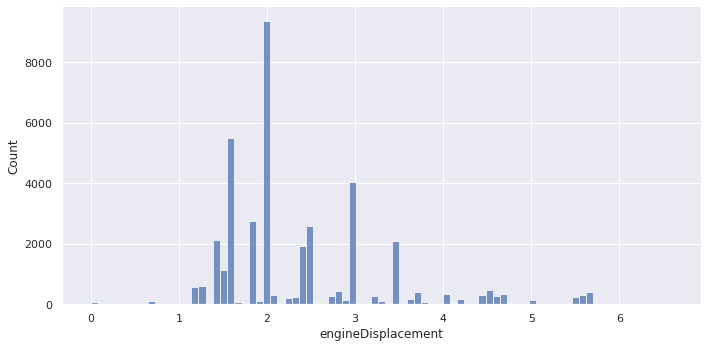

In [34]:
sns.displot(x = train.engineDisplacement, kde = False, rug=False, height=5, aspect=2)

–í–∏–¥–Ω—ã –ø–æ–ø—É–ª—è—Ä–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã –¥–≤–∏–≥–∞—Ç–µ–ª–µ–π 1.5, 2.0, 3.0

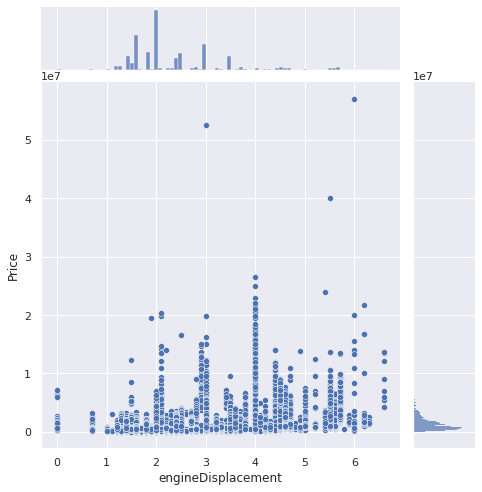

In [35]:
sns.jointplot(x='engineDisplacement', y='Price', data=train, kind='scatter', height=7)

### enginePower - –ú–æ—â–Ω–æ—Å—Ç—å –¥–≤–∏–≥–∞—Ç–µ–ª—è

–ü—Ä–∏–∑–Ω–∞–∫ —á–∏—Å–ª–æ–≤–æ–π. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–º–µ—â–µ–Ω–æ. –ß—Ç–æ –æ–±—ä—è—Å–Ω–∏–º–æ –Ω–∞–∏–±–æ–ª—å—à–µ–π –ø–æ–ø—É–ª—è—Ä–Ω–æ—Å—Ç—å—é –∞–≤—Ç–æ —Å –º–æ—â–Ω–æ—Å—Ç—å—é –æ—Ç 100 –¥–æ 200

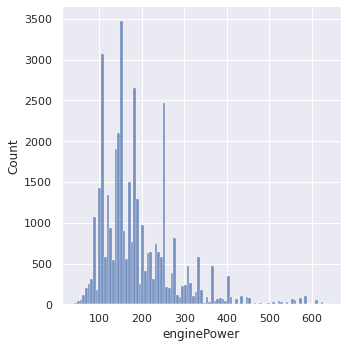

In [36]:
sns.displot(x = train.enginePower, kde = False, rug=False)

–ü—Ä–µ–æ–±–ª–∞–¥–∞—é—Ç –∞–≤—Ç–æ —Å –º–æ—â–Ω–æ—Å—Ç—å—é –æ—Ç 100 –¥–æ 200 –ª.—Å. –ò –≤–∏–¥–µ–Ω "–Ω–∞–ª–æ–≥–æ–≤—ã–π" –ø–∏–∫ –≤ 249 –ª.—Å., –ø–æ—Å–ª–µ –∫–æ—Ç–æ—Ä–æ–≥–æ —Ä–µ–∑–∫–æ –ø–æ–≤—ã—à–∞–µ—Ç—Å—è —Å—Ç–∞–≤–∫–∞ –Ω–∞–ª–æ–≥–∞ –Ω–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª—å. –ê–≤—Ç–æ–ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª–∏ –∏—Å–∫—É—Å—Å—Ç–≤–µ–Ω–æ –æ–≥—Ä–∞–Ω–∏—á–∏–≤–∞—é—Ç –º–æ—â–Ω–æ—Å—Ç—å –¥–≤–∏–≥–∞—Ç–µ–ª–µ–π –Ω–∞ —ç—Ç–æ–º —É—Ä–æ–≤–Ω–µ.
–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –≤–∑–∞–∏–º–æ—Å–≤—è–∑—å —Ü–µ–Ω—ã –∏ –º–æ—â–Ω–æ—Å—Ç–∏.

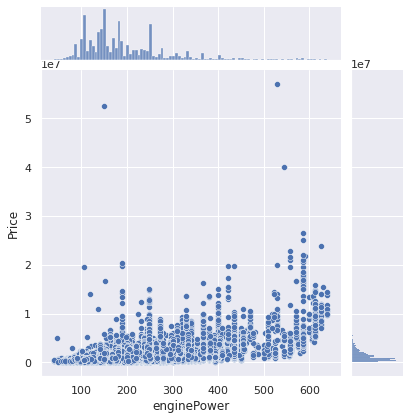

In [37]:
sns.jointplot(x='enginePower', y='Price', data=train, kind='scatter')

–û–∂–∏–¥–∞–ª —É–≤–∏–¥–µ—Ç—å –±–æ–ª–µ–µ –ª–∏–Ω–µ–π–Ω—É—é –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å. 

### equipment_dict - –°–ª–æ–≤–∞—Ä—å —Å –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏–µ–º –∞–≤—Ç–æ–º–æ–±–∏–ª—è
–í test –≤—ã–≥–ª—è–¥–∏—Ç –∫–∞–∫ —Å–ª–æ–≤–∞—Ä—å, –≤ train —É–∂–µ –æ–±—Ä–∞–±–æ—Ç–∞–Ω –≤ –≤–∏–¥–µ —Å–ø–∏—Å–∫–∞ –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏—è. –ë—É–¥–µ–º —Å–ª–æ–≤–∞—Ä—å –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤—ã–≤–∞—Ç—å –≤ —Å–ø–∏—Å–æ–∫, –∞ –∏–∑ —Å–ø–∏—Å–∫–∞ –¥–µ–ª–∞—Ç—å dummy-–ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ

### fuelType - –¢–∏–ø —Ç–æ–ø–ª–∏–≤–∞

In [38]:
sorted(train.fuelType.unique())

['–±–µ–Ω–∑–∏–Ω', '–≥–∞–∑', '–≥–∏–±—Ä–∏–¥', '–¥–∏–∑–µ–ª—å', '—ç–ª–µ–∫—Ç—Ä–æ']

In [39]:
sorted(test.fuelType.unique())

['–±–µ–Ω–∑–∏–Ω', '–≥–∞–∑', '–≥–∏–±—Ä–∏–¥', '–¥–∏–∑–µ–ª—å', '—ç–ª–µ–∫—Ç—Ä–æ']

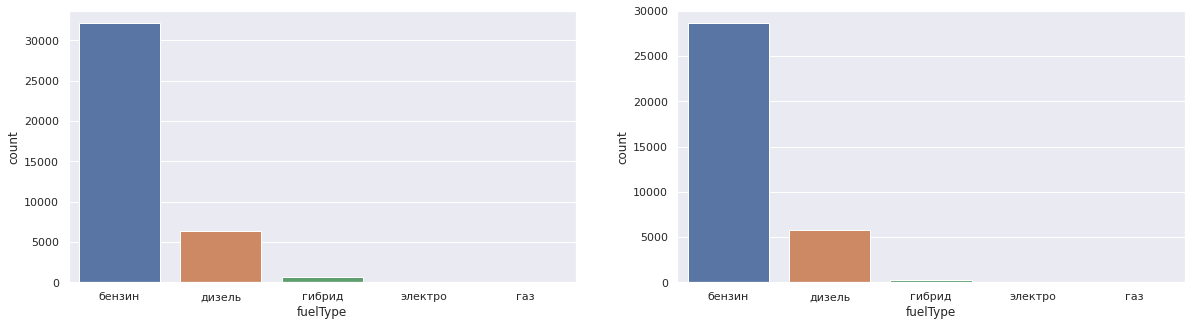

In [40]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='fuelType', data=train, ax=ax[0])
sns.countplot(x='fuelType', data=test, ax=ax[1])
fig.show()


–ü—Ä–∏–∑–Ω–∞–∫ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π. –°–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π –ø–æ —Ç–∏–ø—É —Ç–æ–ø–ª–∏–≤–∞ –æ–¥–∏–Ω–∞–∫–æ–≤–æ–µ

### mileage - –ø—Ä–æ–±–µ–≥

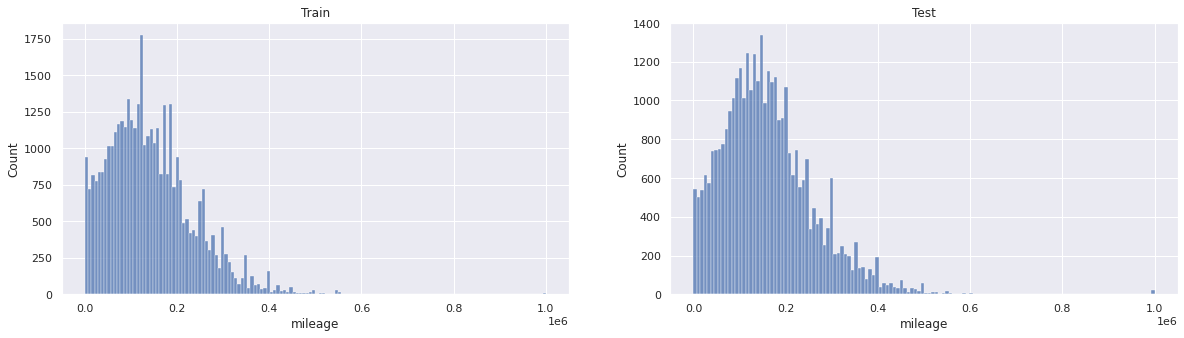

In [41]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.histplot(x='mileage', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.histplot(x='mileage', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ß–∏—Å–ª–æ–≤–æ–π –ø—Ä–∏–∑–Ω–∞–∫. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–º–µ—â–µ–Ω–æ. –ü—Ä–µ–æ–±–ª–∞–¥–∞—é—Ç –∞–≤—Ç–æ —Å –ø—Ä–æ–±–µ–≥–æ–º –æ—Ç 80 –¥–æ 150 —Ç—ã—Å. –∫–º.

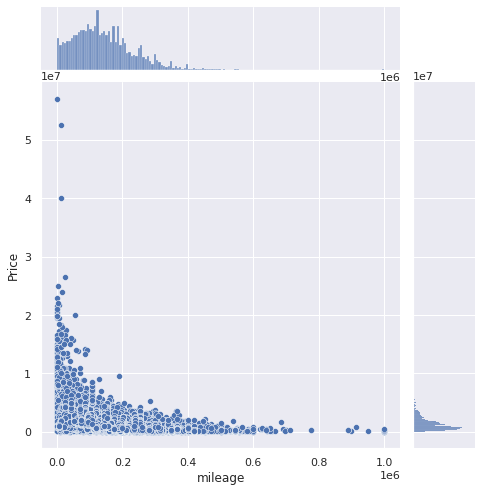

In [42]:
sns.jointplot(x='mileage', y='Price', data=train, kind='scatter', height=7)

–ù—É –¥–ª—è —ç—Ç–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ –≤–∑–∞–∏–º–æ—Å–≤—è–∑—å –ø—Ä–æ–±–µ–≥–∞ –∏ —Ü–µ–Ω—ã –±–æ–ª–µ–µ –Ω–∞–≥–ª—è–¥–Ω–∞, —á–µ–º –¥–ª—è –º–æ—â–Ω–æ—Å—Ç–∏. –ó–∞–≤–∏—Å–∏–º–æ—Å—Ç—å –ø–æ—Ö–æ–∂–∞ –Ω–∞ 1/x.

### modelDate - –î–∞—Ç–∞ –≤—ã—Ö–æ–¥–∞ –º–æ–¥–µ–ª–∏ –≤ –ø—Ä–æ–¥–∞–∂—É

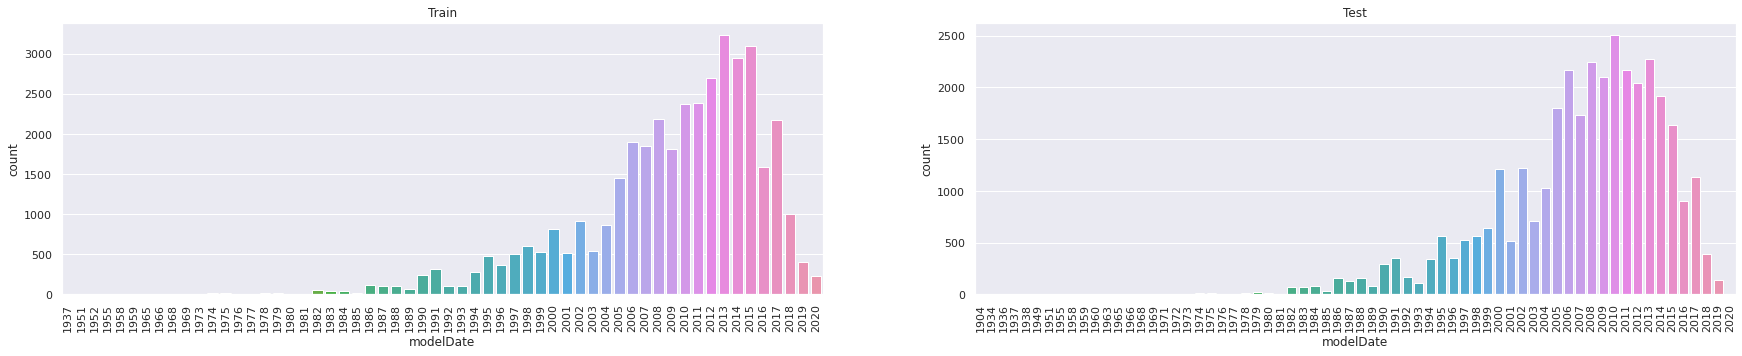

In [43]:
fig, ax =plt.subplots(1,2, figsize=(30,5))
sns.countplot(x='modelDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='modelDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

–ü—Ä–∏–∑–Ω–∞–∫ –±–æ–ª—å—à–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π, —á–µ–º —á–∏—Å–ª–æ–≤–æ–π. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –æ–¥–∏–Ω–∞–∫–æ–≤—ã –≤ train –∏ test
–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Å–≤—è–∑—å —Å —Ü–µ–Ω–æ–π

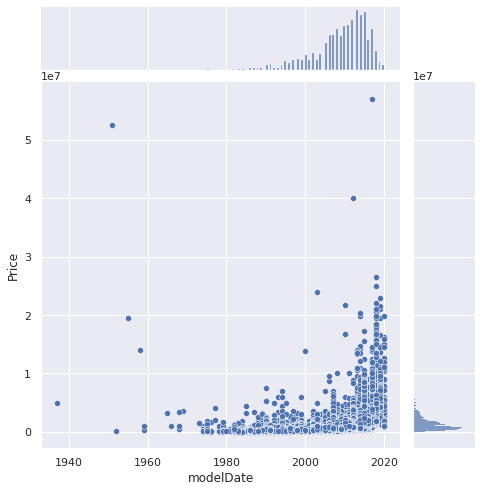

In [44]:
sns.jointplot(x='modelDate', y='Price', data=train, kind='scatter', height=7)

–¢—É—Ç –≤—Å–µ –±–æ–ª–µ–µ-–º–µ–Ω–µ–µ –∑–∞–∫–æ–Ω–æ–º–µ—Ä–Ω–æ, —á–µ–º –ø–æ–∑–¥–Ω–µ–µ –º–æ–¥–µ–ª—å, —Ç–µ–º –æ–Ω–∞ –∏ –¥–æ—Ä–æ–∂–µ

### model_info

test.model_info - –≤—ã–≥–ª—è–¥–∏—Ç –∫–∞–∫ –Ω–µ–∫–∏–π —Å–ø—Ä–∞–≤–æ—á–Ω–∏–∫ –ø–æ –º–æ–¥–µ–ª—è–º, –≤ train –≤—ã–≥—Ä—É–∑–∫–µ –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç. –£–±–∏—Ä–∞–µ–º

### model_name

–ü—Ä–æ—Å—Ç–æ –Ω–∞–∑–≤–∞–Ω–∏–µ –∞–≤—Ç–æ–º–æ–±–∏–ª—è. –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π. 544 —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –≤ test, 540 –≤ train

In [45]:
print(len(test.model_name.unique()))
print(len(train.model_name.unique()))

544
540


### name

–ù–æ–≤–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –Ω–µ –Ω–µ—Å–µ—Ç, —è–≤–ª—è–µ—Ç—Å—è —Å–æ–≤–æ–∫—É–ø–Ω–æ—Å—Ç—å—é –∑–Ω–∞—á–µ–Ω–∏–π –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –º–æ–¥–µ–ª–∏ –∞–≤—Ç–æ, —Ç—Ä–∞–Ω—Å–º–∏—Å—Å–∏–∏, –º–æ—â–Ω–æ—Å—Ç–∏ –¥–≤–∏–≥–∞—Ç–µ–ª—è –∏ –ø—Ä–∏–≤–æ–¥–∞. –£–±–∏—Ä–∞–µ–º

### numberOfDoors - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–≤–µ—Ä–µ–π

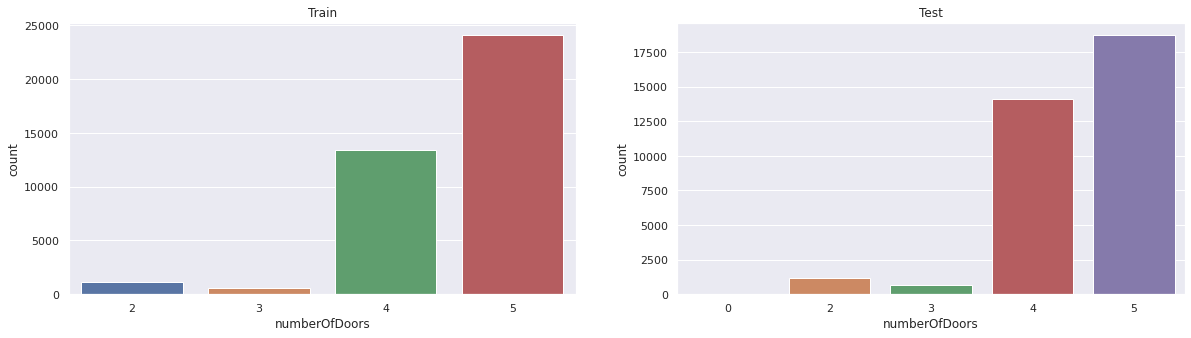

In [46]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='numberOfDoors', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='numberOfDoors', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ train –∏ test —Å–æ–≤–ø–∞–¥–∞–µ—Ç

### parsing_unixtime

–í—Ä–µ–º—è –ø–∞—Ä—Å–∏–Ω–≥–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞ –≤ —Ñ–æ—Ä–º–∞—Ç–µ unixtime. –£–±–∏—Ä–∞–µ–º

### priceCurrency

–í–∞–ª—é—Ç–∞ –æ–±—ä—è–≤–ª–µ–Ω–∏—è. –í—Å–µ –æ–±—ä—è–≤–ª–µ–Ω–∏—è –≤ —Ä—É–±–ª—è—Ö. –£–±–∏—Ä–∞–µ–º

### productionDate - –î–∞—Ç–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª—è

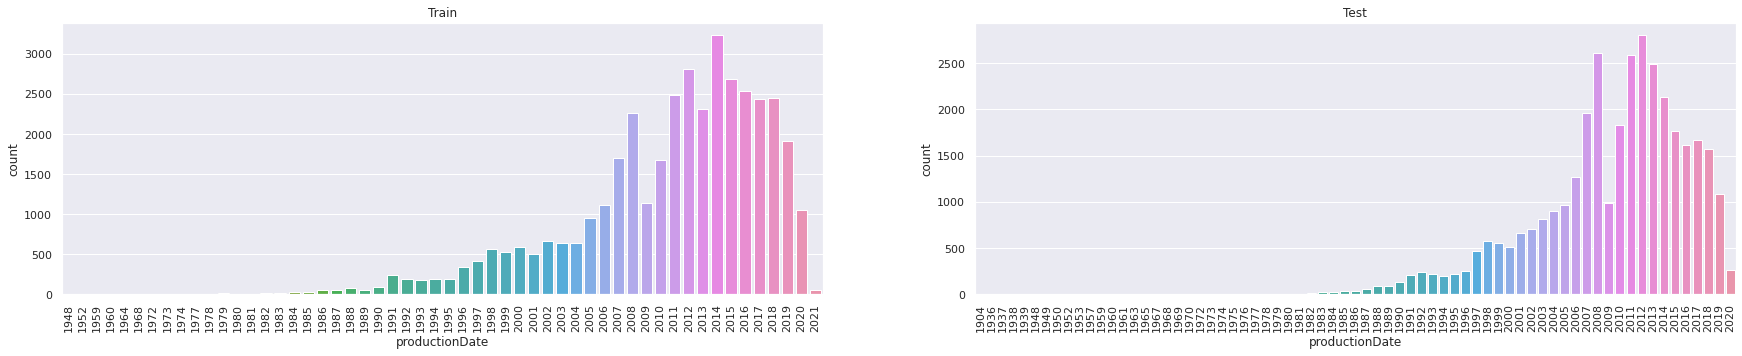

In [47]:
fig, ax =plt.subplots(1,2, figsize=(30,5))

sns.countplot(x='productionDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='productionDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

–ü—Ä–∏–∑–Ω–∞–∫ –±–æ–ª—å—à–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π, —á–µ–º —á–∏—Å–ª–æ–≤–æ–π. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –≤ test –∏ train –ø–æ—Ö–æ–∂–∏. –ó–∞–º–µ—Ç–µ–Ω –∑–Ω–∞—á–∏–º—ã–π –ø—Ä–æ–≤–∞–ª –∫—Ä–∏–∑–∏—Å–Ω–æ–≥–æ 2009 –≥–æ–¥–∞.

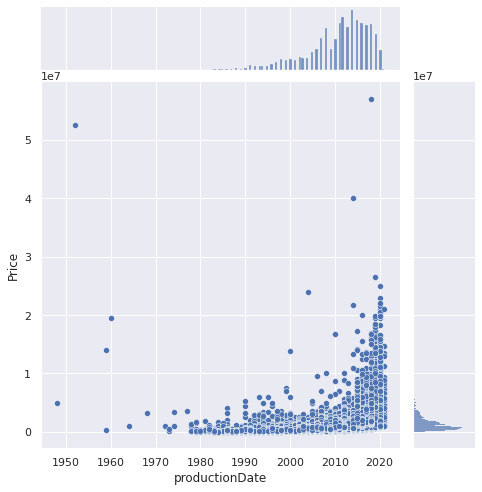

In [48]:
sns.jointplot(x='productionDate', y='Price', data=train, kind='scatter', height=7)

–í–∑–∞–∏–º–æ—Å–≤—è–∑—å —Ü–µ–Ω—ã –∏ –≥–æ–¥–∞ –≤—ã–ø—É—Å–∫–∞ –∞–≤—Ç–æ –ª–æ–≥–∏—á–Ω–∞—è. –í—ã–±—Ä–æ—Å—ã —É–∂–µ –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω—ã.

### sell_id

–ö–∞–∫–æ–π-—Ç–æ –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä –æ–±—ä—è–≤–ª–µ–Ω–∏—è. –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –Ω–µ –Ω–µ—Å–µ—Ç. –£–±–∏—Ä–∞–µ–º

### super_gen

test.super_gen[0]

> '{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 –ª.—Å.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

–æ—á–µ—Ä–µ–¥–Ω–æ–π —Å–ø—Ä–∞–≤–æ—á–Ω–∏–∫ —Å –ø—Ä–∏–≤—è–∑–∫–æ–π –∫ id. –ú–æ–∂–Ω–æ –±—ã–ª–æ –±—ã –∏–∑–≤–ª–µ–∫–∞—Ç—å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é, –Ω–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ –≤—Ä–æ–¥–µ –∏ –Ω–µ—Ç. –£–±–∏—Ä–∞–µ–º.

### vehicleConfiguration

test.vehicleConfiguration[2]
> 'LIFTBACK ROBOT 1.8'

–ü—Ä–∏–∑–Ω–∞–∫ –¥—É–±–ª–∏—Ä—É–µ—Ç –∏–º–µ—é—â—É—é—Å—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é. –£–±–∏—Ä–∞–µ–º.

### vehicleTransmission - –ø—Ä–∏–≤–æ–¥ –∞–≤—Ç–æ–º–æ–±–∏–ª—è

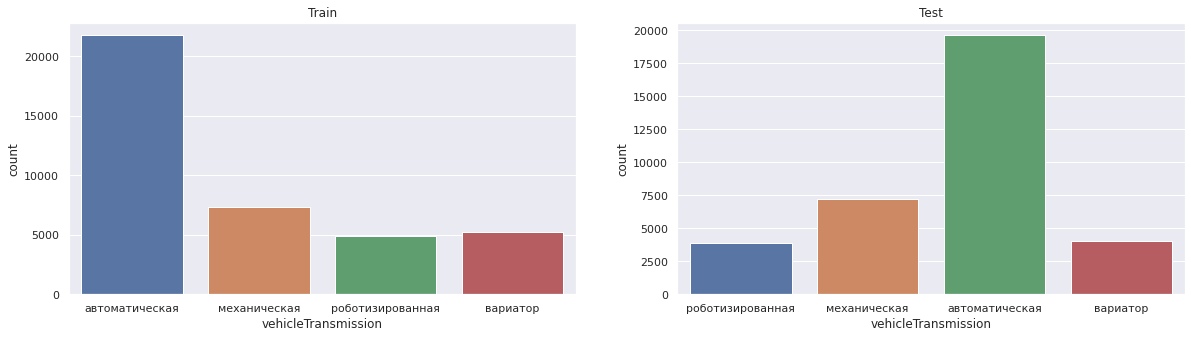

In [49]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='vehicleTransmission', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='vehicleTransmission', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∞ –≤ train –∏ test —Å–æ–≤–ø–∞–¥–∞–µ—Ç

vendor

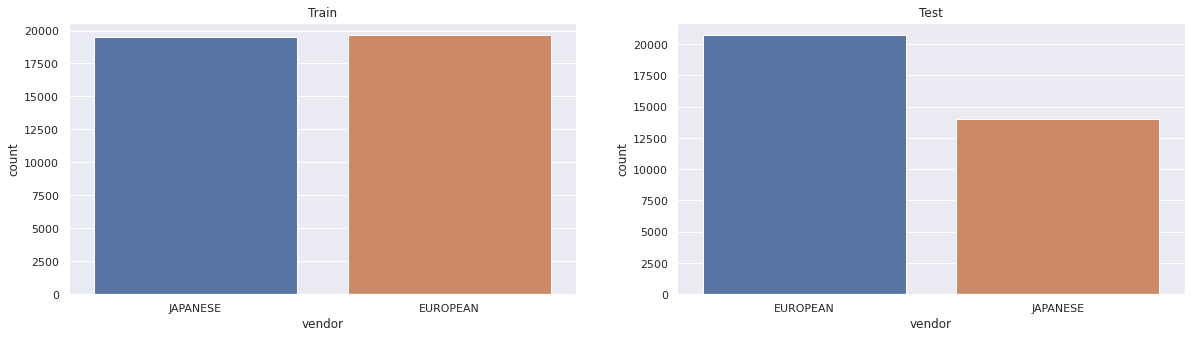

In [50]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='vendor', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='vendor', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ë–∏–Ω–∞—Ä–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫. –í test —è–ø–æ–Ω—Å–∫–∏—Ö –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π –º–µ–Ω—å—à–µ, —á–µ–º –µ–≤—Ä–æ–ø–µ–π—Å–∫–∏—Ö

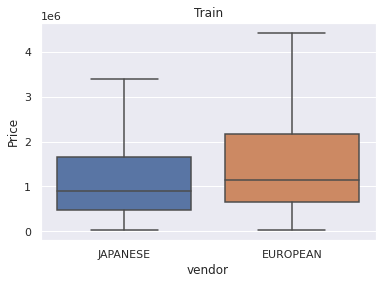

In [51]:
sns.boxplot(x='vendor', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

–ï–≤—Ä–æ–ø–µ–π—Å–∫–∏–µ –∞–≤—Ç–æ–º–æ–±–∏–ª–∏ –¥–æ—Ä–æ–∂–µ

### –í–ª–∞–¥–µ–ª—å—Ü—ã

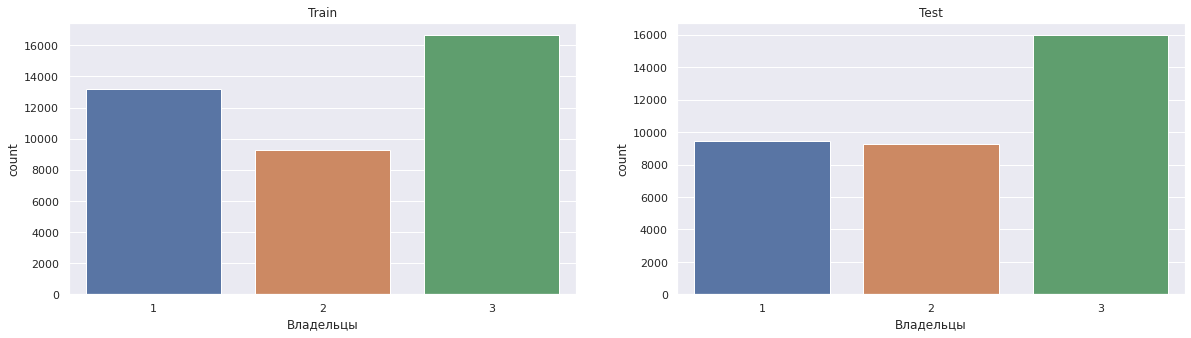

In [52]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='–í–ª–∞–¥–µ–ª—å—Ü—ã', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='–í–ª–∞–¥–µ–ª—å—Ü—ã', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫. –ö–∞—Ä—Ç–∏–Ω–∞ –ø–æ –¥–∞—Ç–∞—Å–µ—Ç–∞–º –ø—Ä–∏–±–ª–∏–∑–∏—Ç–µ–ª—å–Ω–æ –æ–¥–∏–Ω–∞–∫–æ–≤–∞—è

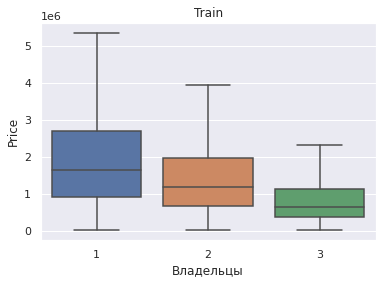

In [53]:
sns.boxplot(x='–í–ª–∞–¥–µ–ª—å—Ü—ã', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

–í–ª–∏—è–Ω–∏–µ –Ω–∞ —Ü–µ–Ω—É –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –≤–ª–∞–¥–µ–ª—å—Ü–µ–≤ - —è–≤–Ω–æ –≤—ã—Ä–∞–∂–µ–Ω–æ

### –í–ª–∞–¥–µ–Ω–∏–µ

–°–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤. –£–±–∏—Ä–∞–µ–º.

### –ü–¢–°

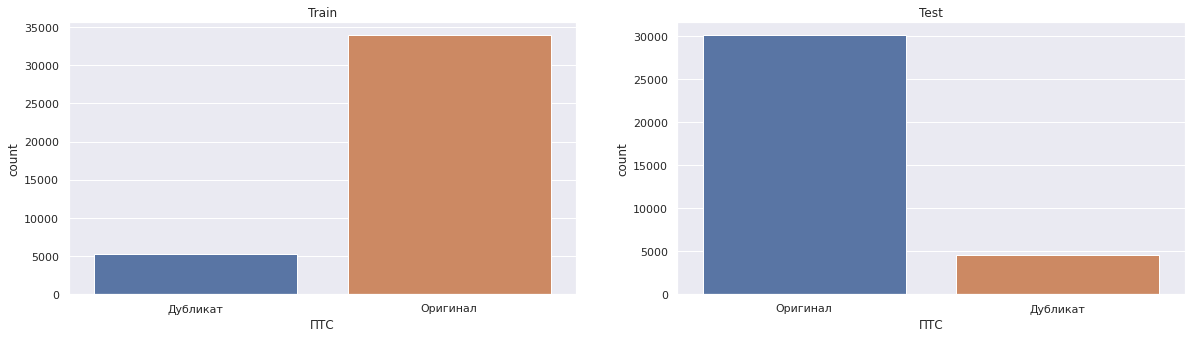

In [54]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='–ü–¢–°', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='–ü–¢–°', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ë–∏–Ω–∞—Ä–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫. –í –æ–±–æ–∏—Ö –¥–∞—Ç–∞—Å–µ—Ç–∞—Ö –ø—Ä–µ–æ–±–ª–∞–¥–∞–µ—Ç –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –∞–≤—Ç–æ —Å –æ—Ä–∏–≥–∏–Ω–∞–ª–æ–º –ü–¢–°

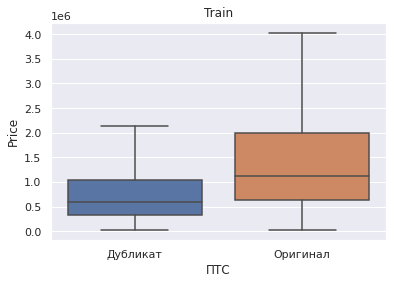

In [55]:
sns.boxplot(x='–ü–¢–°', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

–ú–∞—à–∏–Ω—ã —Å –¥—É–±–ª–∏–∫–∞—Ç–∞–º–∏ –ü–¢–° —Å–∏–ª—å–Ω–æ –¥–µ—à–µ–≤–ª–µ. –ù–æ —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ –∏ —Å—Ç–∞—Ä—à–µ –ø–æ –≤–æ–∑—Ä–∞—Å—Ç—É.

### –ü—Ä–∏–≤–æ–¥

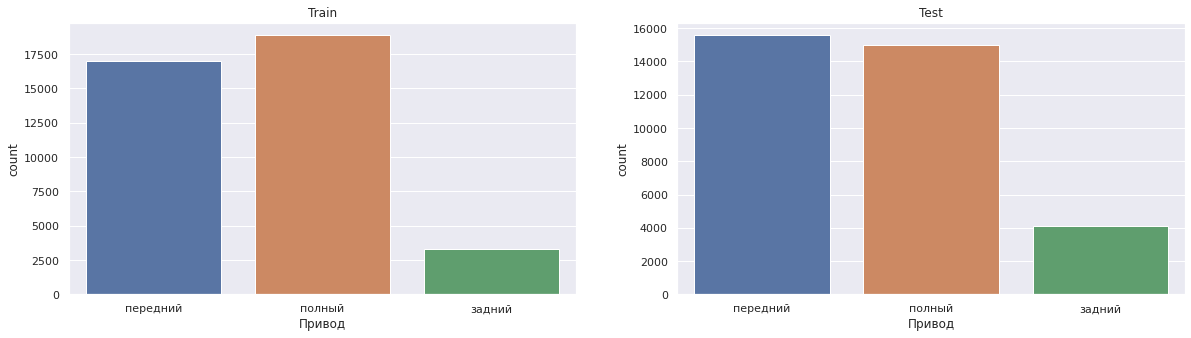

In [56]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='–ü—Ä–∏–≤–æ–¥', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='–ü—Ä–∏–≤–æ–¥', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ü—Ä–∏–∑–Ω–∞–∫ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π, —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–±–ª–∏–∑–∏—Ç–µ–ª—å–Ω–æ –æ–¥–∏–Ω–∞–∫–æ–≤–æ–µ. –ó–∞–¥–Ω–µ–ø—Ä–∏–≤–æ–¥–Ω—ã–µ –∞–≤—Ç–æ –≤ –º–µ–Ω—å—à–∏–Ω—Å—Ç–≤–µ.

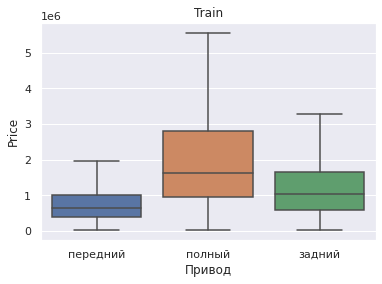

In [57]:
sns.boxplot(x='–ü—Ä–∏–≤–æ–¥', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

–ü–æ–ª–Ω–æ–ø—Ä–∏–≤–æ–¥–Ω—ã–µ –º–∞—à–∏–Ω—ã –¥–æ—Ä–æ–∂–µ. –ü–µ—Ä–µ–¥–Ω–µ–ø—Ä–∏–≤–æ–¥–Ω—ã–µ - –¥–µ—à–µ–≤—ã–π –∏ –º–∞—Å—Å–æ–≤—ã–π —Å–µ–≥–º–µ–Ω—Ç.

### –†—É–ª—å

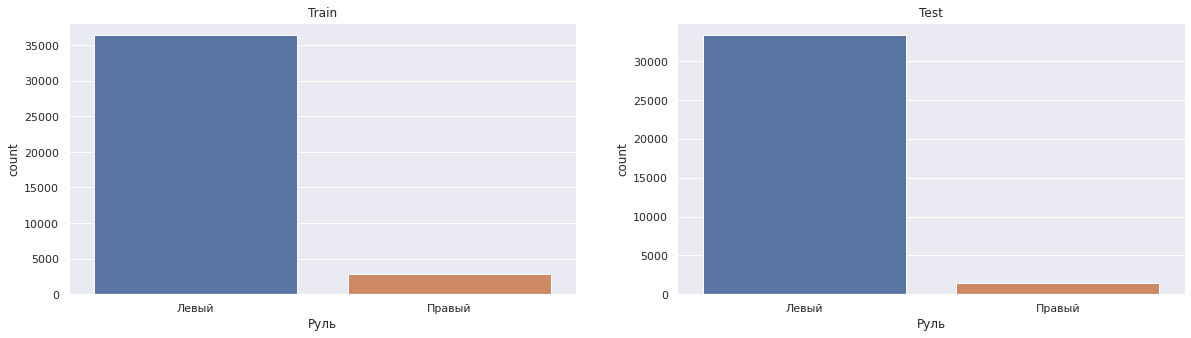

In [58]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='–†—É–ª—å', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='–†—É–ª—å', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

–ü—Ä–∏–∑–Ω–∞–∫ –±–∏–Ω–∞—Ä–Ω—ã–π. –ö–∞—Ä—Ç–∏–Ω–∞ –ø–æ –¥–∞—Ç–∞—Å–µ—Ç–∞–º –æ–¥–∏–Ω–∞–∫–æ–≤–∞—è.

### –°–æ—Å—Ç–æ—è–Ω–∏–µ

–í–µ—Å—å –ø—Ä–∏–∑–Ω–∞–∫ –∏–º–µ–µ—Ç –æ–¥–∏–Ω–∞–∫–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ '–ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞'
–£–±–∏—Ä–∞–µ–º

### –¢–∞–º–æ–∂–Ω—è

–í–µ—Å—å –ø—Ä–∏–∑–Ω–∞–∫ –∏–º–µ–µ—Ç –æ–¥–∏–Ω–∞–∫–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ '–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω'.
–£–±–∏—Ä–∞–µ–º.

## Data Preprocessing

### Preprocessing

In [59]:
# –ö–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º —Ç–µ–∫—Å—Ç–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ c –æ–ø—Ü–∏—è–º–∏ –≤ —Å–ø–∏—Å–æ–∫ 
train.equipment_dict = train.equipment_dict.apply(lambda x: clear_text_list(x))

In [60]:
# –û–±—ä–µ–¥–∏–Ω–∏–º –¥–∞—Ç–∞—Å–µ—Ç—ã, –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ –ø–æ–º–µ—Ç–∏–≤ train –∏ test
train['sample'] = 1 # –ø–æ–º–µ—á–∞–µ–º –≥–¥–µ —É –Ω–∞—Å —Ç—Ä–µ–π–Ω
test['sample'] = 0 # –ø–æ–º–µ—á–∞–µ–º –≥–¥–µ —É –Ω–∞—Å —Ç–µ—Å—Ç
test['Price'] = 0 # –≤ —Ç–µ—Å—Ç–µ —É –Ω–∞—Å –Ω–µ—Ç –∑–Ω–∞—á–µ–Ω–∏—è Price, –∑–∞–ø–æ–ª–Ω—è–µ–º –Ω—É–ª—è–º–∏

data = test.append(train, sort=False).reset_index(drop=True) # –æ–±—ä–µ–¥–∏–Ω—è–µ–º

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73822 entries, 0 to 73821
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             73822 non-null  object 
 1   brand                73822 non-null  object 
 2   car_url              73822 non-null  object 
 3   color                73822 non-null  object 
 4   description          72955 non-null  object 
 5   engineDisplacement   73822 non-null  float64
 6   enginePower          73822 non-null  int64  
 7   equipment_dict       73822 non-null  object 
 8   fuelType             73822 non-null  object 
 9   mileage              73822 non-null  float64
 10  modelDate            73822 non-null  int64  
 11  model_name           73822 non-null  object 
 12  name                 73822 non-null  object 
 13  numberOfDoors        73822 non-null  int64  
 14  productionDate       73822 non-null  int64  
 15  vehicleTransmission  73822 non-null 

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73822 entries, 0 to 73821
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             73822 non-null  object 
 1   brand                73822 non-null  object 
 2   car_url              73822 non-null  object 
 3   color                73822 non-null  object 
 4   description          72955 non-null  object 
 5   engineDisplacement   73822 non-null  float64
 6   enginePower          73822 non-null  int64  
 7   equipment_dict       73822 non-null  object 
 8   fuelType             73822 non-null  object 
 9   mileage              73822 non-null  float64
 10  modelDate            73822 non-null  int64  
 11  model_name           73822 non-null  object 
 12  name                 73822 non-null  object 
 13  numberOfDoors        73822 non-null  int64  
 14  productionDate       73822 non-null  int64  
 15  vehicleTransmission  73822 non-null 

In [63]:
# –†–∞–∑–¥–µ–ª–∏–º features –ø–æ —Ç–∏–ø—É

num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate' ]
    
bin_cols = ['vendor', '–ü–¢–°', '–†—É–ª—å']
       
cat_cols = ['bodyType', 'brand','color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission', '–í–ª–∞–¥–µ–ª—å—Ü—ã',  '–ü—Ä–∏–≤–æ–¥']

len(num_cols)+len(bin_cols)+len(cat_cols)

17

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—é —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

<AxesSubplot:>

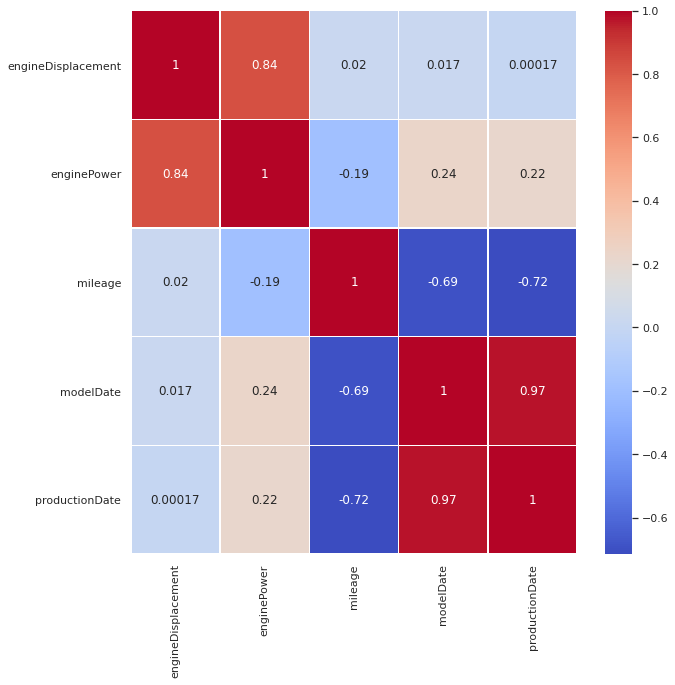

In [64]:
correlation = data[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

–Ø—Å–Ω–æ, —á—Ç–æ –≥–æ–¥ –≤—ã—Ö–æ–¥–∞ –Ω–∞ —Ä—ã–Ω–æ–∫ –º–æ–¥–µ–ª–∏ –æ—á–µ–Ω—å —Å–∏–ª—å–Ω–æ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É–µ—Ç —Å –≥–æ–¥–æ–º –≤—ã–ø—É—Å–∫–∞ –∞–≤—Ç–æ. –¢–∞–∫–∂–µ –æ—á–µ–≤–∏–¥–Ω–∞ –æ–±—Ä–∞—Ç–Ω–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –º–µ–∂–¥—É –ø—Ä–æ–±–µ–≥–æ–º –∏ –≥–æ–¥–æ–º –≤—ã–ø—É—Å–∫–∞ –∏ –ø—Ä—è–º–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –æ–±—ä–µ–º–∞ –∏ –º–æ—â–Ω–æ—Å—Ç–∏ –¥–≤–∏–≥–∞—Ç–µ–ª—è

In [65]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ ############################################################## 
    # —É–±–∏—Ä–∞–µ–º –Ω–µ–Ω—É–∂–Ω—ã–µ –¥–ª—è –º–æ–¥–µ–ª–∏ –ø—Ä–∏–∑–Ω–∞–∫–∏
    df_output.drop(['car_url', 'name', '–í–ª–∞–¥–µ–Ω–∏–µ', '–°–æ—Å—Ç–æ—è–Ω–∏–µ', '–¢–∞–º–æ–∂–Ω—è'], axis=1, inplace=True,)
    
    # –ø–µ—Ä–µ–≤–µ–¥–µ–º –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è –≤ –º–ª
    df_output['engineDisplacement'] = df_output['engineDisplacement']*1000
    
    # ################### Feature Engineering ####################################################
    
    # –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ - —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –ø–æ –ø—Ä–æ–±–µ–≥—É –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –º–æ–¥–µ–ª–∏, –¥–∞—Ç—ã –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞, –º–∞—Ä–∫–∏, –º–æ—â–Ω–æ—Å—Ç–∏ –∏ –ø—Ä.
    df_output = mileage_features('model_name', 'productionDate', df_output)
    df_output = mileage_features('brand', 'productionDate', df_output)
    df_output = mileage_features('enginePower', 'productionDate', df_output)
    df_output = mileage_features('numberOfDoors', 'productionDate', df_output)
    df_output = mileage_features('–†—É–ª—å', 'productionDate', df_output)
    
    df_output.fillna(0, inplace=True)
    
    # –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–∏–µ
    #for col in num_cols:
    #    df_output[col] = df_output[col].apply(lambda w: np.log(w + 1))
    
    # –Ω–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ
    #scaler = RobustScaler()
    #df_output[num_cols] = scaler.fit_transform(df_output[num_cols])
    
    ### –°–æ–∑–¥–∞–µ–º dummy features –∏–∑ —Å–ø–∏—Å–∫–∞ –æ–ø—Ü–∏–π
    
    # –°—Ñ–æ—Ä–º–∏—Ä—É–µ–º —Å–ø–∏—Å–æ–∫ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –æ–ø—Ü–∏–π
    all_equipment = set()
    for item in df_output.equipment_dict:
        for element in item:
            all_equipment.add(element)
    all_equipment = list(all_equipment)
    
    # –°–≥–µ–Ω–µ—Ä–∏—Ä—É–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏
    for equipment in all_equipment:
        df_output[equipment] = df_output.equipment_dict.apply(lambda x: find_equip(x, equipment))
    
    # ################### Clean #################################################### 
    # —É–±–∏—Ä–∞–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –∫–æ—Ç–æ—Ä—ã–µ –µ—â–µ –Ω–µ —É—Å–ø–µ–ª–∏ –æ–±—Ä–∞–±–æ—Ç–∞—Ç—å –∏ –ø—Ä–∏–∑–Ω–∞–∫–∏, –∏–∑ –∫–æ—Ç–æ—Ä—ã—Ö –ø–æ–ª—É—á–µ–Ω—ã –Ω–æ–≤—ã–µ 
    df_output.drop(['description', 'equipment_dict'], axis=1, inplace=True,)
    
    return df_output

In [66]:
data_preproc = preproc_data(data)

In [67]:
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73822 entries, 0 to 73821
Columns: 249 entries, bodyType to alcantara
dtypes: float64(27), int64(212), object(10)
memory usage: 140.8+ MB


In [68]:
data_preproc.isna().sum()

bodyType                                          0
brand                                             0
color                                             0
engineDisplacement                                0
enginePower                                       0
fuelType                                          0
mileage                                           0
modelDate                                         0
model_name                                        0
numberOfDoors                                     0
productionDate                                    0
vehicleTransmission                               0
vendor                                            0
–í–ª–∞–¥–µ–ª—å—Ü—ã                                         0
–ü–¢–°                                               0
–ü—Ä–∏–≤–æ–¥                                            0
–†—É–ª—å                                              0
sample                                            0
Price                                     

# ML

## 1. CatBoost

In [69]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [70]:
# –ü–µ—Ä–µ–≤–æ–¥–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏–∑ float –≤ int (–∏–Ω–∞—á–µ catboost –≤—ã–¥–∞–µ—Ç –æ—à–∏–±–∫—É)
    
col_types = data_preproc.dtypes.reset_index()
col_types.columns=['Name', 'type']
float_to_convert = list(col_types[col_types['type']=='float64']['Name'])
  
for feature in float_to_convert:
    data_preproc[feature]=data_preproc[feature].astype('int32')

In [72]:
# –æ—Ç–±–µ—Ä–µ–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏, –¥–ª—è –ø–µ—Ä–µ–¥–∞—á–∏ –≤ –º–æ–¥–µ–ª—å
cat_cols_catboost = []
num_cols_catboost = ['enginePower', 'mileage']
    
for el in data_preproc.drop(['Price', 'sample'], axis=1).columns:
    if el not in num_cols_catboost:
        cat_cols_catboost.append(el)
len(cat_cols_catboost)
    

245

–†–∞–∑–¥–µ–ª–∏–º –¥–∞—Ç–∞—Å–µ—Ç –æ–±—Ä–∞—Ç–Ω–æ –Ω–∞ —Ç—Ä–µ–π–Ω –∏ —Ç–µ—Å—Ç

In [73]:
train_data = data_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = data_preproc.query('sample == 0').drop(['sample', 'Price'], axis=1)

y = train_data.Price.values
X = train_data.drop(['Price'], axis=1)

–†–∞–∑–æ–±—ä–µ–º —Ç—Ä–µ–π–Ω –Ω–∞ –æ–±—É—á–∞—é—â—É—é –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫–∏

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

–ü–æ–¥–±–µ—Ä–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è CatBoost

In [75]:
#model = CatBoostRegressor(iterations = 50,
#                          random_seed = RANDOM_SEED,
#                          cat_features=cat_cols_catboost,
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE']
#                         )
#
#start = datetime.now()
#grid = {'learning_rate': [0.05, 0.1, 0.15],
#        'depth': [10, 12],
#        'l2_leaf_reg': [7, 9]}
#
#grid_search_result = model.grid_search(grid
#                                     ,X=X_train
#                                     ,y=np.log(y_train)
#                                     ,plot=True
#                                     ,verbose=False)
#
#print('\n–ù–∞–∏–ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: ', grid_search_result['params'])

–û–±—É—á–∏–º –º–æ–¥–µ–ª—å

In [76]:
#model = CatBoostRegressor(iterations=1000, #ITERATIONS,
#                          learning_rate=0.12,
#                          random_seed=RANDOM_SEED,
#                          #depth=8,
#                          #l2_leaf_reg=7,
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE']
#                         )
#model.fit(X_train, y_train,
#         cat_features=cat_cols_catboost,
#         eval_set=(X_test, y_test),
#         verbose_eval=100,
#         use_best_model=True,
#         plot=True
#         )

In [78]:
#predict = model.predict(X_test)

# –æ—Ü–µ–Ω–∏–≤–∞–µ–º —Ç–æ—á–Ω–æ—Å—Ç—å
#print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: {(mape(y_test, predict))*100:0.2f}%")

–õ—É—á—à–∞—è –ø–æ–ª—É—á–µ–Ω–Ω–∞—è –º–µ—Ç—Ä–∏–∫–∞ - –≤ —Ä–∞–π–æ–Ω–µ 13,9%. –ù–∞ –ª–∏–¥–µ—Ä–±–æ—Ä–¥–µ - 20.87, –Ω–æ –±–µ–∑ —É—á–µ—Ç–∞ –ø–æ–ø—Ä–∞–≤–∫–∏ –Ω–∞ —É–¥–æ—Ä–æ–∂–∞–Ω–∏–µ. 

## –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –¥–∞—Ç–∞—Å–µ—Ç, —á—Ç–æ–±—ã –µ–≥–æ –º–æ–∂–Ω–æ –±—ã–ª–æ —Å–∫–æ—Ä–º–∏—Ç—å –¥—Ä—É–≥–∏–º –º–æ–¥–µ–ª—è–º.

In [79]:
col_types = data_preproc.dtypes.reset_index()
col_types.columns=['Name', 'type']
num_cols = list(col_types[col_types['type'] !='object']['Name'])
num_cols

['engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'numberOfDoors',
 'productionDate',
 '–í–ª–∞–¥–µ–ª—å—Ü—ã',
 'sample',
 'Price',
 'min_mileage by model_name productionDate',
 'max_mileage by model_name productionDate',
 'mean_mileage by model_name productionDate',
 'median_mileage by model_name productionDate',
 'std_mileage by model_name productionDate',
 'min_mileage by brand productionDate',
 'max_mileage by brand productionDate',
 'mean_mileage by brand productionDate',
 'median_mileage by brand productionDate',
 'std_mileage by brand productionDate',
 'min_mileage by enginePower productionDate',
 'max_mileage by enginePower productionDate',
 'mean_mileage by enginePower productionDate',
 'median_mileage by enginePower productionDate',
 'std_mileage by enginePower productionDate',
 'min_mileage by numberOfDoors productionDate',
 'max_mileage by numberOfDoors productionDate',
 'mean_mileage by numberOfDoors productionDate',
 'median_mileage by numberOfDoors producti

In [80]:
num_cols=[
 'engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'productionDate',
 'min_mileage by model_name productionDate',
 'max_mileage by model_name productionDate',
 'mean_mileage by model_name productionDate',
 'median_mileage by model_name productionDate',
 'std_mileage by model_name productionDate',
 'min_mileage by brand productionDate',
 'max_mileage by brand productionDate',
 'mean_mileage by brand productionDate',
 'median_mileage by brand productionDate',
 'std_mileage by brand productionDate',
 'min_mileage by enginePower productionDate',
 'max_mileage by enginePower productionDate',
 'mean_mileage by enginePower productionDate',
 'median_mileage by enginePower productionDate',
 'std_mileage by enginePower productionDate',
 'min_mileage by numberOfDoors productionDate',
 'max_mileage by numberOfDoors productionDate',
 'mean_mileage by numberOfDoors productionDate',
 'median_mileage by numberOfDoors productionDate',
 'std_mileage by numberOfDoors productionDate',
 'min_mileage by –†—É–ª—å productionDate',
 'max_mileage by –†—É–ª—å productionDate',
 'mean_mileage by –†—É–ª—å productionDate',
 'median_mileage by –†—É–ª—å productionDate',
 'std_mileage by –†—É–ª—å productionDate',
 ]

In [81]:
# –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–∏–µ
for col in num_cols:
    data_preproc[col] = data_preproc[col].apply(lambda w: np.log(w + 1))
    
# –Ω–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ
scaler = RobustScaler()
data_preproc[num_cols] = scaler.fit_transform(data_preproc[num_cols])

#–±–∏–Ω–∞—Ä–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

label_encoder = LabelEncoder()

for column in bin_cols:
    data_preproc[column] = label_encoder.fit_transform(data_preproc[column])

# one-hot-encoding
data_preproc = pd.get_dummies(data_preproc, columns=cat_cols)
data_preproc.shape

(73822, 928)

In [82]:
# –†–∞–∑–¥–µ–ª–∏–º –¥–∞—Ç–∞—Å–µ—Ç –Ω–∞ —Ç—Ä–µ–π–Ω –∏ —Ç–µ—Å—Ç –æ–±—Ä–∞—Ç–Ω–æ
train_data = data_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = data_preproc.query('sample == 0').drop(['sample', 'Price'], axis=1)

y = train_data.Price.values
X = train_data.drop(['Price'], axis=1)

In [83]:
# –†–∞–∑–¥–µ–ª–∏–º —Ç—Ä–µ–π–Ω –Ω–∞ –æ–±—É—á–∞—é—â—É—é –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫–∏
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## 2. RandomForest

In [ ]:
# –ü–æ–¥–±–µ—Ä–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
#               'max_features': ['auto', 'sqrt'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#rfr = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=100, cv=3,
#                               verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
#rf_random.fit(X_train, np.log(y_train))
#rf_random.best_params_

#rfr = rf_random.best_estimator_


In [84]:
# –û–±—É—á–∏–º –º–æ–¥–µ–ª—å
#rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                            n_estimators=2000,
#                            min_samples_split=2,
#                            min_samples_leaf=1,
#                            max_features='sqrt',
#                            max_depth=None,
#                            bootstrap=False,
#                            n_jobs=-1,
#                            verbose=1)

#rfr.fit(X_train, np.log(y_train))



In [85]:
#predict_rfr = np.exp(rfr.predict(X_test))

#print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: {(mape(y_test, predict_rfr))*100:0.2f}%")

–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: 13.83%.

## 3. Gradient Boosting Regressor

In [86]:
# –ü–æ–¥–±–µ—Ä–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4]}

#gbr = GradientBoostingRegressor()
#gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions=random_grid, n_iter=100, cv=3,
#                                verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
#gbr_random.fit(X_train, np.log(y_train))
#gbr_random.best_params_

In [ ]:
# –û–±—É—á–∏–º –º–æ–¥–µ–ª—å
#gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                n_estimators=800,
#                                min_samples_split=5,
#                                min_samples_leaf=4,
#                                max_features='sqrt',
#                                max_depth=9
#                               )
#gbr.fit(X_train, np.log(y_train))

In [87]:
predict_gbr = np.exp(gbr.predict(X_test))
print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: {(mape(y_test, predict_gbr))*100:0.2f}%")

–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: 12.67%. –ù–∞ –ª–∏–¥–µ—Ä–±–æ—Ä–¥–µ - 16.40

## 4. –ë—ç–≥–≥–∏–Ω–≥ —Å–æ —Å–ª—É—á–∞–π–Ω—ã–º –ª–µ—Å–æ–º - –ù–µ –ø–æ–ª—É—á–∏–ª–æ—Å—å. –ü–µ—Ä–µ–ª–∏–º–∏—Ç –ø–æ –ø–∞–º—è—Ç–∏ –Ω–∞ Kaggle

In [88]:
#rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                           n_estimators=300,
#                            min_samples_split=2,
#                            min_samples_leaf=1,
#                            max_features='sqrt',
#                            max_depth=None,
#                            bootstrap=False,
#                            n_jobs=-1,
#                            verbose=1)
#
#rfr.fit(X_train, np.log(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   58.1s finished


RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=300,
                      n_jobs=-1, random_state=42, verbose=1)

In [90]:
#bag_model = BaggingRegressor(rfr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
#bag_model.fit(X_train, y_train)

In [ ]:
#predict_bag = bag_model.predict(X_test)

# –æ—Ü–µ–Ω–∏–≤–∞–µ–º —Ç–æ—á–Ω–æ—Å—Ç—å
#print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: {(mape(y_test, predict_bag))*100:0.2f}%")

## 5. –ë—ç–≥–≥–∏–Ω–≥ —Å –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–º –±—É—Å—Ç–∏–Ω–≥–æ–º

In [ ]:
#bag_model = BaggingRegressor(gbr, n_estimators=10, n_jobs=-1, random_state=RANDOM_SEED)
#bag_model.fit(X_train, y_train)

In [ ]:
#predict_bag = bag_model.predict(X_test)

# –æ—Ü–µ–Ω–∏–≤–∞–µ–º —Ç–æ—á–Ω–æ—Å—Ç—å
#print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: {(mape(y_test, predict_bag))*100:0.2f}%")

–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: 14.18%

## 6. Blending

In [93]:
#–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —Ä–∞–∑–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –±—É–¥–µ–º —É—Å—Ä–µ–¥–Ω—è—Ç—å
#models = [GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                    n_estimators=800,
#                                    min_samples_split=5,
#                                    min_samples_leaf=4,
#                                    max_features='sqrt',
#                                    max_depth=9
#                                   ),
#          BaggingRegressor(
#              ExtraTreeRegressor(random_state=RANDOM_SEED),
#              n_estimators=500,
#              random_state=RANDOM_SEED,
#              n_jobs=-1,
#              verbose=2)]


def model_predict(models, X_train, y_train, X_val):
    pred_df = pd.DataFrame()
    for model_ in tqdm(models):
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_val)
        pred_df[str(model_)[:6]] = y_pred               
    return pred_df


#pred_temp = model_predict(models, X_train, y_train, X_test)
#pred_temp['y_pred'] = pred_temp.mean(axis=1)

#predict = np.array(pred_temp['y_pred'])

# –æ—Ü–µ–Ω–∏–≤–∞–µ–º —Ç–æ—á–Ω–æ—Å—Ç—å
#print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: {(mape(y_test, predict))*100:0.2f}%")

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.9s finished


–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: 13.56%


–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: 13.56%. –õ—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –Ω–∞ –ª–∏–¥–µ—Ä–±–æ—Ä–¥–µ - —Ç—É—Ç. 15.58, 46-–µ –º–µ—Å—Ç–æ.

–°–¥–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –Ω–∞ –≤—Å–µ–º —Ç—Ä–µ–π–Ω–µ 

In [95]:
pred_temp = model_predict(models, X, np.log(y), test_data)
pred_temp['y_pred'] = pred_temp.mean(axis=1)

predict = np.array(pred_temp['y_pred'])

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished


In [96]:
# Submission –¥–ª—è –±–ª–µ–Ω–¥–∏–Ω–≥–∞

# –û–±—Ä–∞—Ç–Ω–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ 
predict_submission = np.exp(predict)

# –û–∫—Ä—É–≥–ª–∏–º –ø—Ä–µ–¥–∏–∫—Ç –∏ —Å–∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä—É–µ–º –Ω–∞ 0.9 - –ø–æ–ø—Ä–∞–≤–æ—á–Ω—ã–π –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç, —É—á–∏—Ç—ã–≤–∞—é—â–∏–π —Ä–æ—Å—Ç —Ü–µ–Ω –Ω–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª–∏.
predict_submission = (predict_submission // 1000) * 1000 * 0.9

## Stacking

In [103]:
#estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                       n_estimators=800,
#                                       min_samples_split=5,
#                                       min_samples_leaf=4,
#                                       max_features='sqrt',
#                                       max_depth=9), n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)),
#             ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
#                                      colsample_bytree=0.5,
#                                      learning_rate=0.05,
#                                      #max_depth=12,
#                                      alpha=1,
#                                      n_estimators=500))
#           ]

#st_ensemble = StackingRegressor(estimators=estimators,
#                                final_estimator = CatBoostRegressor(iterations=1000,
#                                                                    learning_rate=0.12,
#                                                                    random_seed=RANDOM_SEED,
#                                                                    #depth=8,
#                                                                    #l2_leaf_reg=7,
#                                                                    eval_metric='MAPE',
#                                                                    custom_metric=['R2', 'MAE']
#                                                                   ),
#                                n_jobs=-1,
#                                verbose=5
#                               )

    
#st_ensemble.fit(X_train, np.log(y_train))

#predict_ensemble = np.exp(st_ensemble.predict(X_test))

#print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")

0:	learn: 0.0475648	total: 68.1ms	remaining: 1m 8s
1:	learn: 0.0422732	total: 76.4ms	remaining: 38.1s
2:	learn: 0.0376525	total: 83.8ms	remaining: 27.9s
3:	learn: 0.0337483	total: 90.8ms	remaining: 22.6s
4:	learn: 0.0301131	total: 98ms	remaining: 19.5s
5:	learn: 0.0269482	total: 105ms	remaining: 17.4s
6:	learn: 0.0242145	total: 112ms	remaining: 15.9s
7:	learn: 0.0218956	total: 118ms	remaining: 14.6s
8:	learn: 0.0198560	total: 125ms	remaining: 13.7s
9:	learn: 0.0181002	total: 132ms	remaining: 13.1s
10:	learn: 0.0166214	total: 139ms	remaining: 12.5s
11:	learn: 0.0154204	total: 144ms	remaining: 11.8s
12:	learn: 0.0143498	total: 150ms	remaining: 11.4s
13:	learn: 0.0134472	total: 156ms	remaining: 11s
14:	learn: 0.0127009	total: 162ms	remaining: 10.6s
15:	learn: 0.0120697	total: 168ms	remaining: 10.4s
16:	learn: 0.0115486	total: 176ms	remaining: 10.2s
17:	learn: 0.0111569	total: 183ms	remaining: 9.97s
18:	learn: 0.0108283	total: 189ms	remaining: 9.77s
19:	learn: 0.0105585	total: 195ms	remain

180:	learn: 0.0093023	total: 1.25s	remaining: 5.66s
181:	learn: 0.0093019	total: 1.26s	remaining: 5.65s
182:	learn: 0.0093015	total: 1.26s	remaining: 5.64s
183:	learn: 0.0093011	total: 1.27s	remaining: 5.63s
184:	learn: 0.0093009	total: 1.28s	remaining: 5.63s
185:	learn: 0.0092991	total: 1.28s	remaining: 5.62s
186:	learn: 0.0092981	total: 1.29s	remaining: 5.62s
187:	learn: 0.0092966	total: 1.3s	remaining: 5.61s
188:	learn: 0.0092947	total: 1.31s	remaining: 5.61s
189:	learn: 0.0092944	total: 1.31s	remaining: 5.6s
190:	learn: 0.0092931	total: 1.32s	remaining: 5.6s
191:	learn: 0.0092929	total: 1.33s	remaining: 5.59s
192:	learn: 0.0092912	total: 1.34s	remaining: 5.59s
193:	learn: 0.0092908	total: 1.34s	remaining: 5.58s
194:	learn: 0.0092905	total: 1.35s	remaining: 5.56s
195:	learn: 0.0092890	total: 1.35s	remaining: 5.55s
196:	learn: 0.0092877	total: 1.36s	remaining: 5.55s
197:	learn: 0.0092862	total: 1.37s	remaining: 5.54s
198:	learn: 0.0092860	total: 1.37s	remaining: 5.53s
199:	learn: 0.0

357:	learn: 0.0091850	total: 2.42s	remaining: 4.35s
358:	learn: 0.0091842	total: 2.43s	remaining: 4.34s
359:	learn: 0.0091839	total: 2.44s	remaining: 4.34s
360:	learn: 0.0091831	total: 2.45s	remaining: 4.33s
361:	learn: 0.0091830	total: 2.45s	remaining: 4.32s
362:	learn: 0.0091821	total: 2.46s	remaining: 4.31s
363:	learn: 0.0091818	total: 2.46s	remaining: 4.3s
364:	learn: 0.0091814	total: 2.47s	remaining: 4.29s
365:	learn: 0.0091806	total: 2.48s	remaining: 4.29s
366:	learn: 0.0091795	total: 2.48s	remaining: 4.28s
367:	learn: 0.0091790	total: 2.49s	remaining: 4.27s
368:	learn: 0.0091783	total: 2.49s	remaining: 4.26s
369:	learn: 0.0091779	total: 2.5s	remaining: 4.26s
370:	learn: 0.0091772	total: 2.51s	remaining: 4.25s
371:	learn: 0.0091771	total: 2.51s	remaining: 4.24s
372:	learn: 0.0091767	total: 2.52s	remaining: 4.24s
373:	learn: 0.0091759	total: 2.53s	remaining: 4.23s
374:	learn: 0.0091749	total: 2.53s	remaining: 4.22s
375:	learn: 0.0091740	total: 2.54s	remaining: 4.21s
376:	learn: 0.

516:	learn: 0.0091155	total: 3.6s	remaining: 3.36s
517:	learn: 0.0091152	total: 3.61s	remaining: 3.36s
518:	learn: 0.0091146	total: 3.62s	remaining: 3.35s
519:	learn: 0.0091142	total: 3.62s	remaining: 3.35s
520:	learn: 0.0091140	total: 3.63s	remaining: 3.34s
521:	learn: 0.0091136	total: 3.64s	remaining: 3.33s
522:	learn: 0.0091136	total: 3.65s	remaining: 3.32s
523:	learn: 0.0091135	total: 3.65s	remaining: 3.32s
524:	learn: 0.0091133	total: 3.66s	remaining: 3.31s
525:	learn: 0.0091129	total: 3.67s	remaining: 3.31s
526:	learn: 0.0091122	total: 3.68s	remaining: 3.3s
527:	learn: 0.0091116	total: 3.69s	remaining: 3.29s
528:	learn: 0.0091112	total: 3.69s	remaining: 3.29s
529:	learn: 0.0091106	total: 3.7s	remaining: 3.28s
530:	learn: 0.0091105	total: 3.71s	remaining: 3.28s
531:	learn: 0.0091102	total: 3.72s	remaining: 3.27s
532:	learn: 0.0091097	total: 3.73s	remaining: 3.27s
533:	learn: 0.0091096	total: 3.74s	remaining: 3.26s
534:	learn: 0.0091096	total: 3.74s	remaining: 3.25s
535:	learn: 0.0

683:	learn: 0.0090618	total: 4.79s	remaining: 2.21s
684:	learn: 0.0090617	total: 4.79s	remaining: 2.2s
685:	learn: 0.0090606	total: 4.8s	remaining: 2.2s
686:	learn: 0.0090604	total: 4.81s	remaining: 2.19s
687:	learn: 0.0090600	total: 4.82s	remaining: 2.18s
688:	learn: 0.0090594	total: 4.82s	remaining: 2.18s
689:	learn: 0.0090592	total: 4.83s	remaining: 2.17s
690:	learn: 0.0090590	total: 4.84s	remaining: 2.16s
691:	learn: 0.0090584	total: 4.84s	remaining: 2.15s
692:	learn: 0.0090582	total: 4.85s	remaining: 2.15s
693:	learn: 0.0090580	total: 4.85s	remaining: 2.14s
694:	learn: 0.0090575	total: 4.86s	remaining: 2.13s
695:	learn: 0.0090566	total: 4.86s	remaining: 2.12s
696:	learn: 0.0090563	total: 4.87s	remaining: 2.12s
697:	learn: 0.0090559	total: 4.88s	remaining: 2.11s
698:	learn: 0.0090556	total: 4.89s	remaining: 2.1s
699:	learn: 0.0090556	total: 4.89s	remaining: 2.1s
700:	learn: 0.0090552	total: 4.9s	remaining: 2.09s
701:	learn: 0.0090548	total: 4.91s	remaining: 2.08s
702:	learn: 0.0090

867:	learn: 0.0090066	total: 5.97s	remaining: 907ms
868:	learn: 0.0090061	total: 5.97s	remaining: 900ms
869:	learn: 0.0090061	total: 5.98s	remaining: 893ms
870:	learn: 0.0090059	total: 5.98s	remaining: 886ms
871:	learn: 0.0090056	total: 5.99s	remaining: 879ms
872:	learn: 0.0090055	total: 6s	remaining: 873ms
873:	learn: 0.0090048	total: 6s	remaining: 866ms
874:	learn: 0.0090045	total: 6.01s	remaining: 859ms
875:	learn: 0.0090043	total: 6.02s	remaining: 852ms
876:	learn: 0.0090040	total: 6.03s	remaining: 845ms
877:	learn: 0.0090038	total: 6.03s	remaining: 838ms
878:	learn: 0.0090037	total: 6.04s	remaining: 831ms
879:	learn: 0.0090034	total: 6.04s	remaining: 824ms
880:	learn: 0.0090031	total: 6.05s	remaining: 817ms
881:	learn: 0.0090027	total: 6.05s	remaining: 810ms
882:	learn: 0.0090023	total: 6.06s	remaining: 803ms
883:	learn: 0.0090020	total: 6.07s	remaining: 796ms
884:	learn: 0.0090015	total: 6.07s	remaining: 789ms
885:	learn: 0.0090009	total: 6.08s	remaining: 782ms
886:	learn: 0.0090

–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAPE: 12.63%

In [ ]:
# –û–±—É—á–∏–º —Å—Ç–µ–∫–∏–Ω–≥–æ–≤—É—é –º–æ–¥–µ–ª—å –Ω–∞ –≤—Å–µ–º —Ç—Ä–µ–π–Ω–µ
# st_ensemble.fit(X, np.log(y))

# Submission

In [97]:
# –ü—Ä–µ–¥–∏–∫—Ç –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω–æ–≥–æ –±—É—Å—Ç–∏–Ω–≥–∞
#predict_submission = (np.exp(gbr.predict(test_data))// 1000) * 1000 * 0.9

# –ü—Ä–µ–¥–∏–∫—Ç —Å—Ç–µ–∫–∏–Ω–≥–∞
# predict_submission = (np.exp(st_ensemble.predict(test_data)) // 1000) * 1000 * 0.9
predict_submission

array([ 662000., 1069000.,  932000., ...,  188000., 1180000., 1138000.])

In [98]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id      price
0  1100575026   662000.0
1  1100549428  1069000.0
2  1100658222   932000.0
3  1100937408   796000.0
4  1101037972   732000.0
5  1100912634   832000.0
6  1101228730   668000.0
7  1100165896   484000.0
8  1100768262  2034000.0
9  1101218501   757000.0